tgb - 1/3/2022 - Happy new year! The goal of this notebook is to decompose the inputs into distinct PCA components to facilitate causal discovery using PCMCI. The causal discovery results will then be used for objective feature selection. The rationale behind using PCA first is to work with more "orthogonal" parents, as neighboring vertical levels can be highly correlated, which complicates using PCMCI on the full input profile. The steps for this notebook are as follows:

1. Load the training set and its normalized version    
2. Apply PCA on randomly selected subsets and see how many modes are necessary to explain most of the variance    
3. Check the number of modes necessary to reach reasonable mean squared error when predicting subgrid tendencies   
4. Apply lagged correlation, Granger causality, and the PC algorithm to select parents for each output     
5. Repeat for climate-invariant case  

# Imports

In [49]:
from cbrain.climate_invariant import *

import matplotlib as mpl
import numpy as np

import pickle
from sklearn.decomposition import PCA

In [50]:
fz = 15 # Here we define the fontsize 
lw = 2 # the linewidth
siz = 75 # and the scattered dots' size

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

In [51]:
path_data = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'

# Load dataset and define data generator

In [52]:
in_vars = ['QBP','TBP','VBP','PS','SOLIN','SHFLX','LHFLX'] # We take the large-scale climate state as inputs
out_vars = ['PHQ','TPHYSTND','FSNT','FSNS','FLNT','FLNS', 'PRECT'] # and we output the response of clouds/storms to these climate conditions
path_train = path_data + 'Aqua_0K_withVBP/2021_09_02_TRAIN_For_Nando.nc'

## Try PCA on physically scaled data

### Load dataset

In [ ]:
train_data = xr.open_dataset(path_train)

### Isolate inputs

In [ ]:
input_idx = np.arange(0,94)

In [ ]:
train_data

In [ ]:
input_dic = {}
input_dic['var_names'] = input_idx

In [ ]:
train_input_data = train_data.isel(indexers=input_dic)

In [ ]:
train_input_data

### Load normalization file to access the approximate standard deviations

In [ ]:
path_input_norm = path_data + '001_norm.nc'

In [ ]:
norm_dataset = xr.open_dataset(path_input_norm)

In [ ]:
norm_dataset

In [ ]:
input_idx = np.concatenate(
    (np.arange(0,30),
     np.arange(90,154)))

In [ ]:
input_dic = {}
input_dic['var_names'] = input_idx

In [ ]:
norm_input_data = norm_dataset.isel(input_dic)

In [ ]:
norm_input_data

In [ ]:
fig,ax = plt.subplots(5,2,figsize=(15,15))

ax[0][0].plot(norm_input_data['std'][:30].values)
ax[0][0].set_ylabel('Q [g/kg]')
ax[0][0].set_title('Standard Deviation')
ax[1][0].plot(norm_input_data['std'][30:60].values)
ax[1][0].set_ylabel('T [K]')
ax[2][0].plot(norm_input_data['std'][60:90].values)
ax[2][0].set_ylabel('V [m/s]')
ax[3][0].scatter(0,norm_input_data['std'][90].values/1e5)
ax[3][0].set_ylabel('P$_{s}$ [10$^{5}$Pa]')
ax[3][0].grid()
ax[4][0].scatter([0,1,2],norm_input_data['std'][91:].values)
ax[4][0].set_ylabel('S$_{0}$,SHF,LHF[Wm$^{2}$]')
ax[4][0].grid()

ax[0][1].plot(norm_input_data['max'][:30].values-norm_input_data['min'][:30].values)
ax[0][1].set_ylabel('Q [g/kg]')
ax[0][1].set_title('Range')
ax[1][1].plot(norm_input_data['max'][30:60].values-norm_input_data['min'][30:60].values)
ax[1][1].set_ylabel('T [K]')
ax[2][1].plot(norm_input_data['max'][60:90].values-norm_input_data['min'][60:90].values)
ax[2][1].set_ylabel('V [m/s]')
ax[3][1].scatter(0,norm_input_data['max'][90].values/1e5-norm_input_data['min'][90].values/1e5)
ax[3][1].set_ylabel('P$_{s}$ [10$^{5}$Pa]')
ax[3][1].grid()
ax[4][1].scatter([0,1,2],norm_input_data['max'][91:].values-norm_input_data['min'][91:].values)
ax[4][1].set_ylabel('S$_{0}$,SHF,LHF[Wm$^{2}$]')
ax[4][1].grid()

### Rescale inputs physically so that they all have units $J/kg$

In [ ]:
RHO_0 = 1 # Approximate surface air density [in kg/m^3]
V_0 = 1000 # Approximate wind velocity**2/(2*wind_velocity) [in m/s]

In [ ]:
scale_inp = []
for i in range(30): scale_inp.append(L_S)
for i in range(30): scale_inp.append(C_P)
for i in range(30): scale_inp.append(V_0)
scale_inp.append(1/RHO_0)
for i in range(3): scale_inp.append(G*DT/(P0/100))
scale_inp = np.array(scale_inp)

Comment: This may not be optimal because there is no unique choice to scale all inputs to $J/kg$ given that pressure, non-squared velocity, and even power per unit surface do not have a very natural equivalent in $J/kg$

In [ ]:
fig,ax = plt.subplots(5,2,figsize=(15,20))

ax[0][0].plot(norm_input_data['std'][:30].values*scale_inp[:30])
ax[0][0].set_ylabel('Q [J/kg]')
ax[0][0].set_title('STD after physical normalization')
ax[1][0].plot(norm_input_data['std'][30:60].values*scale_inp[30:60])
ax[1][0].set_ylabel('T [J/kg]')
ax[2][0].plot(norm_input_data['std'][60:90].values*scale_inp[60:90])
ax[2][0].set_ylabel('V [J/kg]')
ax[3][0].scatter(0,(norm_input_data['std'][90].values*scale_inp[90]))
ax[3][0].set_ylabel('P$_{s}$ [J/kg]')
ax[3][0].ticklabel_format(useOffset=False)
ax[3][0].grid()
ax[4][0].scatter([0,1,2],norm_input_data['std'][91:].values*scale_inp[91:])
ax[4][0].set_ylabel('S$_{0}$,SHF,LHF[J/kg]')
ax[4][0].grid()

ax[0][1].plot(scale_inp[:30]*(norm_input_data['max'][:30].values-norm_input_data['min'][:30].values))
ax[0][1].set_ylabel('Q [J/kg]')
ax[0][1].set_title('Range after physical normalization')
ax[1][1].plot(scale_inp[30:60]*(norm_input_data['max'][30:60].values-norm_input_data['min'][30:60].values))
ax[1][1].set_ylabel('T [J/kg]')
ax[2][1].plot(scale_inp[60:90]*(norm_input_data['max'][60:90].values-norm_input_data['min'][60:90].values))
ax[2][1].set_ylabel('V [J/kg]')
ax[3][1].scatter(0,scale_inp[90]*(norm_input_data['max'][90].values-norm_input_data['min'][90].values))
ax[3][1].set_ylabel('P$_{s}$ [J/kg]')
ax[3][1].ticklabel_format(useOffset=False)
ax[3][1].grid()
ax[4][1].scatter([0,1,2],scale_inp[91:]*(norm_input_data['max'][91:].values-norm_input_data['min'][91:].values))
ax[4][1].set_ylabel('S$_{0}$,SHF,LHF[J/kg]')
ax[4][1].grid()

## Try PCA on normalized data

### Create normalized dataset

In [ ]:
scale_dict = pickle.load(open(path_data+'CIML_Zenodo/009_Wm2_scaling.pkl','rb'))

In [ ]:
N_batch = 8192

train_gen_BF = DataGeneratorCI(
    data_fn = path_train,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path_input_norm,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    shuffle = False,
    batch_size=N_batch
)

In [ ]:
train_gen_BF[0][0].shape

In [ ]:
new_values = np.zeros((train_gen_BF.n_samples,94))

In [ ]:
for ibatch in range((train_gen_BF.n_samples)//N_batch):
    if ibatch % 10==0: print('progress=','%2.2f' % (100*ibatch/((train_gen_BF.n_samples)//N_batch)),
                              '%','               ',end='\r')
    new_values[ibatch*N_batch:((1+ibatch)*N_batch),:] = train_gen_BF[ibatch][0]

In [ ]:
new_values.shape

### Find its principal components

In [ ]:
pca = PCA()

In [ ]:
pca.fit(new_values)

In [ ]:
plt.plot(pca.explained_variance_ratio_,color='k')
ax = plt.gca()

ax2 = ax.twinx()
ax2.set_ylabel('Variance explained',color='b')
var_explained = np.cumsum(pca.explained_variance_ratio_)
ax2.plot(var_explained,color='b')
ax2.tick_params(axis='y',color='b',labelcolor='b')
plt.grid()

In [ ]:
var_explained

In [ ]:
pca.components_.shape

### Save PCA in pkl file

In [ ]:
path_PKL = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/PKL_DATA/'

In [ ]:
path_savePCA = path_PKL + '2022_01_04_PCA_of_2021_09_02_TRAIN_For_Nando.pkl'

In [ ]:
pickle.dump(pca,open(path_savePCA,'wb'))

### Plot principal components

Load coordinates for plotting

In [16]:
path_folder = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/'

In [17]:
pathAQ_0K = path_folder + 'fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.00'

In [18]:
coor = xr.open_dataset(pathAQ_0K+'00-03-01-00000.nc')

Plot PCA eigenvectors

In [ ]:
eig1 = pca.components_[0,:]

In [ ]:
plt.plot(eig1[:30],coor.lev,label='q')
plt.plot(eig1[30:60],coor.lev,label='T')
plt.plot(eig1[60:90],coor.lev,label='V')
plt.scatter(eig1[90:],[1000,750,500,250])
plt.legend()
plt.grid()
plt.gca().invert_yaxis()

In [ ]:
eig1 = pca.components_[1,:]

In [ ]:
plt.plot(eig1[:30],coor.lev,label='q')
plt.plot(eig1[30:60],coor.lev,label='T')
plt.plot(eig1[60:90],coor.lev,label='V')
plt.scatter(eig1[90:],[1000,750,500,250])
plt.legend()
plt.grid()
plt.gca().invert_yaxis()

In [ ]:
eig1 = pca.components_[2,:]

In [ ]:
plt.plot(eig1[:30],coor.lev,label='q')
plt.plot(eig1[30:60],coor.lev,label='T')
plt.plot(eig1[60:90],coor.lev,label='V')
plt.scatter(eig1[90:],[1000,750,500,250])
plt.legend()
plt.grid()
plt.gca().invert_yaxis()

In [ ]:
eig1 = pca.components_[3,:]

In [ ]:
plt.plot(eig1[:30],coor.lev,label='q')
plt.plot(eig1[30:60],coor.lev,label='T')
plt.plot(eig1[60:90],coor.lev,label='V')
plt.scatter(eig1[90:],[1000,750,500,250])
plt.legend()
plt.grid()
plt.gca().invert_yaxis()

In [ ]:
eig1 = pca.components_[4,:]

In [ ]:
plt.plot(eig1[:30],coor.lev,label='q')
plt.plot(eig1[30:60],coor.lev,label='T')
plt.plot(eig1[60:90],coor.lev,label='V')
plt.scatter(eig1[90:],[1000,750,500,250])
plt.legend()
plt.grid()
plt.gca().invert_yaxis()

In [ ]:
eig1 = pca.components_[5,:]

In [ ]:
plt.plot(eig1[:30],coor.lev,label='q')
plt.plot(eig1[30:60],coor.lev,label='T')
plt.plot(eig1[60:90],coor.lev,label='V')
plt.scatter(eig1[90:],[1000,750,500,250])
plt.legend()
plt.grid()
plt.gca().invert_yaxis()

## Transform training dataset using PCA

### PCA transform

See [https://stackoverflow.com/questions/36566844/pca-projection-and-reconstruction-in-scikit-learn]

In [ ]:
PCA_train_set = pca.transform(new_values)

In [ ]:
PCA_train_set.shape

In [ ]:
PCA_train_set_min = np.min(PCA_train_set)

In [ ]:
PCA_train_set_max = np.max(PCA_train_set)

In [ ]:
PCA_train_set_mean = np.mean(PCA_train_set)

In [ ]:
PCA_train_set_std = np.std(PCA_train_set)

In [ ]:
print('mean,std,min,max=',PCA_train_set_mean,PCA_train_set_std,PCA_train_set_min,PCA_train_set_max)

### Save training dataset in netCDF file

In [ ]:
train_data

In [ ]:
train_data['vars'][:,94:].shape

Coordinates

In [ ]:
var_names_full = []
for i in range(94):
    var_names_full.append('PCA_'+str(i+1))
var_names_full = np.array(var_names_full)
var_names_full = np.append(var_names_full,train_data['var_names'][94:].values)

In [ ]:
var_names_full

In [ ]:
new_coor = {}
new_coor['var_names'] = var_names_full

Data variables

In [ ]:
PCA_train_set.shape

In [ ]:
full_data = np.concatenate(
    (PCA_train_set,
     train_data['vars'][:,94:].values),
    axis=1
)

In [ ]:
full_data.shape

In [ ]:
new_var = {}
new_var['vars'] = (['sample','var_names'],full_data)

In [ ]:
new_train = xr.Dataset(
    data_vars = new_var,
    coords = new_coor
)

In [ ]:
new_train

In [ ]:
path_save_train = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/2022_01_04_Train_PCA_Nando.nc'

In [ ]:
new_train.to_netcdf(path_save_train,mode='w')

### New norm file

Coordinates

In [ ]:
norm_dataset

In [ ]:
var_names_full = norm_dataset['var_names'].values
var_names_full_single = norm_dataset['var_names_single'].values

In [ ]:
for i in range(94):
    var_names_full = np.append(var_names_full,'PCA_'+str(i+1))
    var_names_full_single = np.append(var_names_full_single,'PCA_'+str(i+1))

In [ ]:
new_coor = {}
new_coor['var_names'] = var_names_full
new_coor['var_names_single']= var_names_full_single

Data

In [ ]:
norm_data = {}

In [ ]:
KEY = ['mean','std','min','max']

In [ ]:
for key in KEY:
    if key=='mean': PCA_key = PCA_train_set_mean
    elif key=='std': PCA_key = PCA_train_set_std
    elif key=='max': PCA_key = PCA_train_set_max
    elif key=='min': PCA_key = PCA_train_set_min
    norm_data[key] = norm_dataset[key].values
    for i in range(94):
        norm_data[key] = np.append(norm_data[key],PCA_key)

In [ ]:
norm_data['mean'].shape

In [ ]:
key0 = 'std_by_var'

In [ ]:
norm_data[key0] = norm_dataset[key0].values
for i in range(94): norm_data[key0] = np.append(norm_data[key0],PCA_train_set_std)

In [ ]:
# for i in range(94):
#     norm_data['mean'].append(PCA_train_set_mean)
#     norm_data['std'].append(PCA_train_set_std)
#     norm_data['max'].append(PCA_train_set_max)
#     norm_data['min'].append(PCA_train_set_min)
#     norm_data['std_by_var'].append(PCA_train_set_std)

In [ ]:
# for key in KEY:
#     norm_data[key] = np.array(norm_data[key])

In [ ]:
norm_data_dict = {}

In [ ]:
for key in KEY:
    norm_data_dict[key] = (['var_names'],norm_data[key])
norm_data_dict[key0] = (['var_names_single'],norm_data[key0])

In [ ]:
new_norm = xr.Dataset(
    data_vars = norm_data_dict,
    coords = new_coor
)

In [ ]:
new_norm

In [ ]:
path_save_norm = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/2022_01_04_Norm_PCA_Nando.nc'

In [ ]:
new_norm.to_netcdf(path_save_norm,mode='w')

# Try training with different number of PCA components

## Load data

In [5]:
path_save_dir = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'

In [6]:
path_train = '2022_01_04_Train_PCA_Nando.nc'
path_newnorm = '2022_01_04_Norm_PCA_Nando.nc'

In [7]:
out_vars = ['PHQ','TPHYSTND','FSNT','FSNS','FLNT','FLNS','PRECT']

Choose number of PCA components below

In [ ]:
N_PCA = 50

In [ ]:
path_PKL = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/PKL_DATA/'
path_savePCA = path_PKL + '2022_01_04_PCA_of_2021_09_02_TRAIN_For_Nando.pkl'

In [ ]:
PCA_data = pickle.load(open(path_savePCA,'rb'))

In [ ]:
var_explained = np.cumsum(PCA_data.explained_variance_ratio_)

In [ ]:
print('With '+str(N_PCA)+' PCA components, the explained variance is '+\
      '%02.1f' % (100*var_explained[N_PCA-1])+'% of the total variance')

In [ ]:
in_vars = []
for i in range(N_PCA):
    in_vars.append('PCA_'+str(i+1))
in_vars = np.array(in_vars)

In [ ]:
in_vars

## Data generator

In [ ]:
train_gen_PCA = {}

In [ ]:
N_batch = 8192

In [ ]:
train_gen_PCA = DataGeneratorCI(
    data_fn = path_save_dir+path_train,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path_save_dir+path_newnorm,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=N_batch
)

In [ ]:
test_norm = xr.open_dataset(path_save_dir+path_newnorm)

In [ ]:
test_norm

In [ ]:
train_gen_PCA[0][1]

## NN

In [ ]:
inp = Input(shape=(N_PCA,)) ## input after rh and tns transformation
densout = Dense(128, activation='linear')(inp)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
dense_out = Dense(65, activation='linear')(densout)
model = tf.keras.models.Model(inp, dense_out)

In [ ]:
model.summary()

In [ ]:
model.compile(tf.keras.optimizers.Adam(), loss=mse)

In [ ]:
# Where to save the model
path_HDF5 = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/'
save_name = '2022_01_04_PCA_'+str(N_PCA)

In [ ]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_pos = ModelCheckpoint(path_HDF5+save_name+'.hdf5',save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
Nep = 20
model.fit_generator(train_gen_PCA, epochs=Nep, validation_data=train_gen_PCA,\
                    callbacks=[earlyStopping, mcp_save_pos])

Number of PCA components = 10
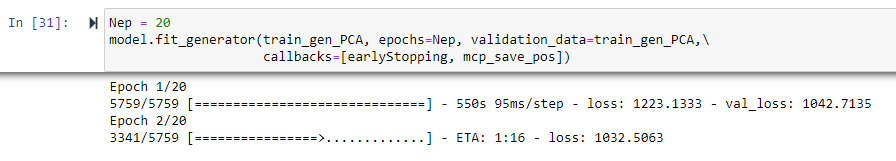

Number of PCA components = 15

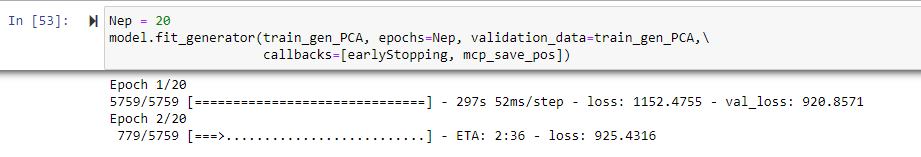

Number of PCA components = 20
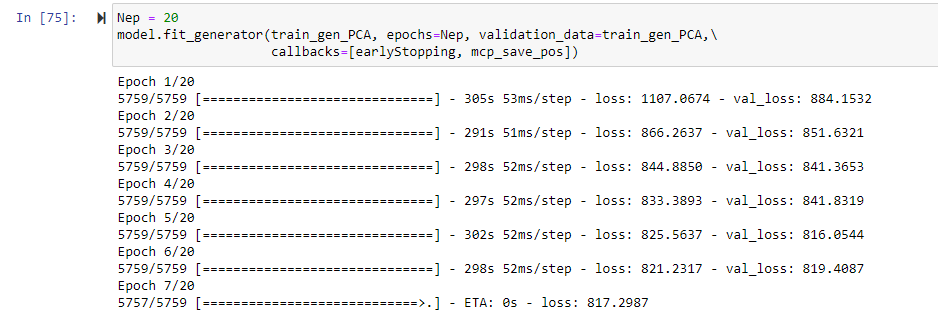

Number of PCA components = 30

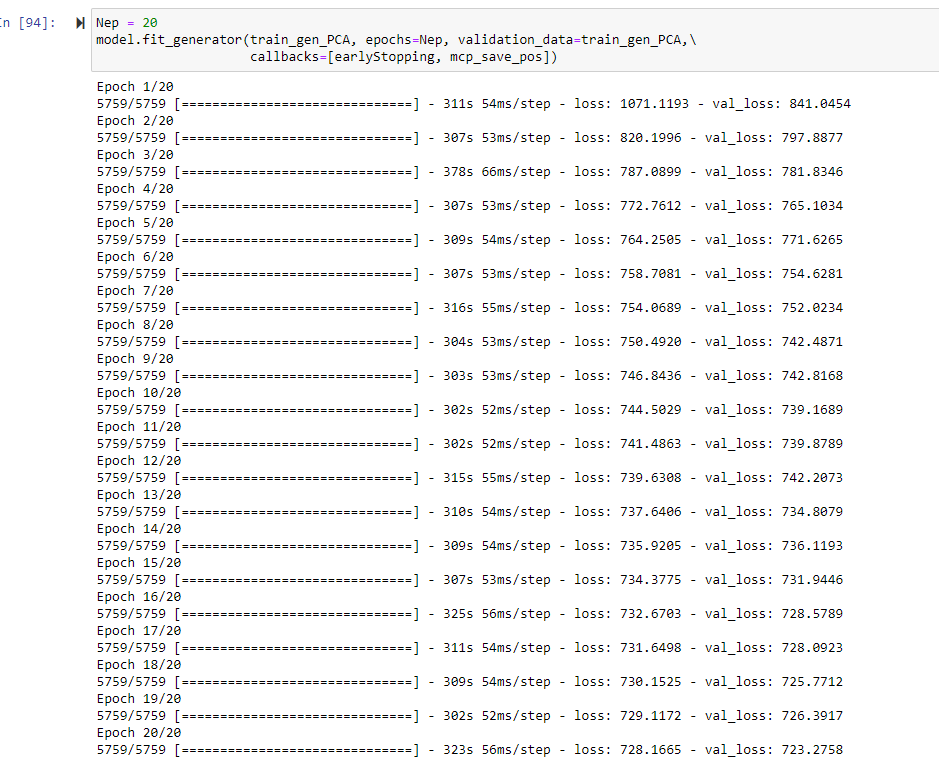

Number of PCA components = 50
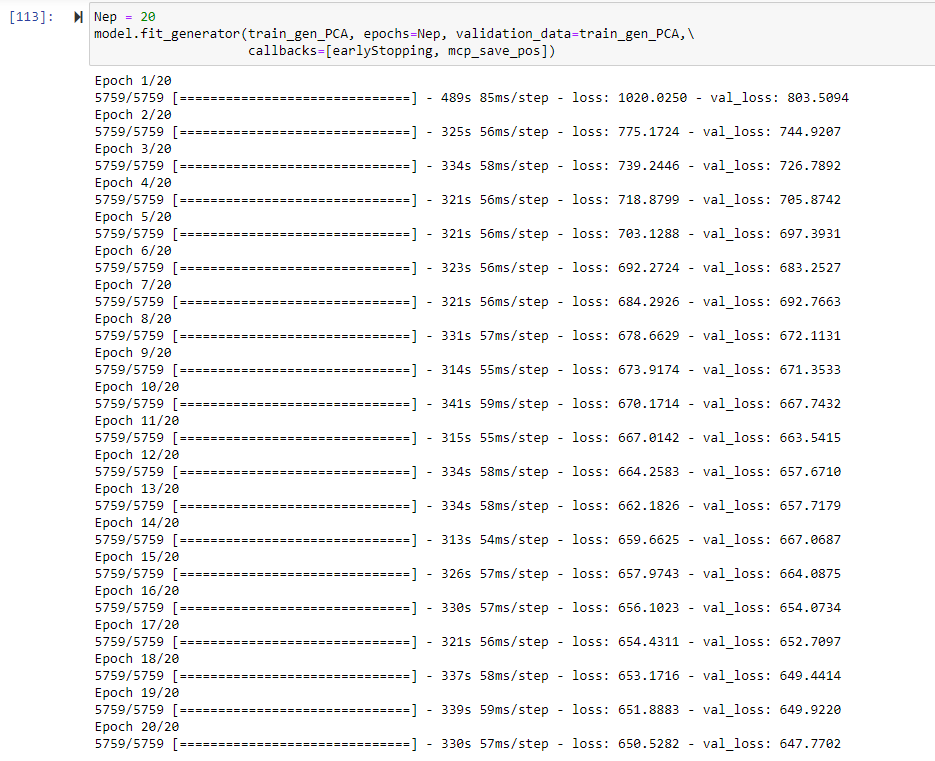

# Test different causal discovery algorithms on raw vs PCA data

## Reorganize the training sets to make them time series

In [5]:
path_folder = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/'
pathAQ_0K = path_folder + 'fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.00'
coor = xr.open_dataset(pathAQ_0K+'00-03-01-00000.nc')

In [6]:
path_train_raw = path_data + 'Aqua_0K_withVBP/2021_09_02_TRAIN_For_Nando.nc'
path_train_PCA = path_data + '2022_01_04_Train_PCA_Nando.nc'

In [7]:
train_data_raw = xr.open_dataset(path_train_raw)
#train_data_PCA = xr.open_dataset(path_train_PCA)

In [8]:
Nlat = 64
Nlon = 128
NT = int(train_data_raw['vars'].shape[0]/(Nlat*Nlon))
Nvars = 159

In [9]:
inputs_idx = np.arange(0,94)
output_idx = np.arange(94,Nvars)

### Raw data

In [10]:
raw_vars = train_data_raw['vars'].values

In [11]:
raw_vars = np.reshape(raw_vars,(NT,Nlat,Nlon,Nvars))

In [12]:
raw_vars_name_inp = train_data_raw['var_names'][inputs_idx].values
for ivar in range(3):
    for ilev in range(30):
        raw_vars_name_inp[30*ivar+ilev] = \
        raw_vars_name_inp[30*ivar+ilev] + \
        '%2.0f'%(coor.lev[ilev].values)

raw_vars_name_oup = train_data_raw['var_names'][94+np.arange(0,65)].values
for ivar in range(2):
    for ilev in range(30):
        raw_vars_name_oup[30*ivar+ilev] = \
        raw_vars_name_oup[30*ivar+ilev] + \
        '%2.0f'%(coor.lev[ilev].values)

In [13]:
raw_vars.shape

(5759, 64, 128, 159)

In [14]:
iNST = 59

In [29]:
NST = np.mean(raw_vars[:,:,:,59],axis=0)

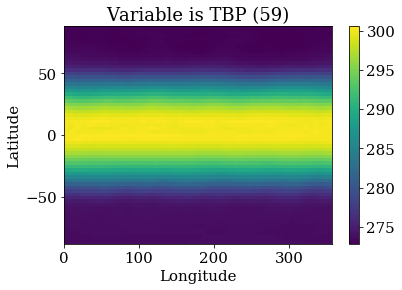

In [30]:
plt.pcolormesh(coor.lon,coor.lat,NST)
plt.colorbar()
plt.title('Variable is '+(train_data_raw['var_names'].values)[iNST]+' ('+str(iNST)+')');
plt.xlabel('Longitude');
plt.ylabel('Latitude');

In [ ]:
raw_vars_name_inp

In [ ]:
raw_vars_name_oup

### PCA data

In [13]:
pca_vars = train_data_PCA['vars'].values

In [14]:
pca_vars = np.reshape(pca_vars,(NT,Nlat,Nlon,Nvars))

In [15]:
pca_vars.shape

(5759, 64, 128, 159)

In [41]:
iPCA1 = 0

In [42]:
PCA1 = np.mean(pca_vars[:,:,:,iPCA1],axis=0)

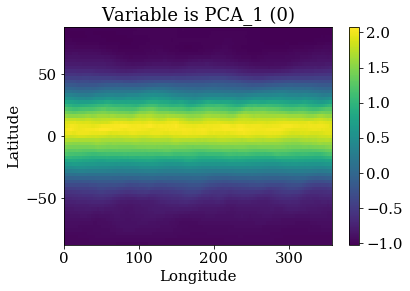

In [43]:
plt.pcolormesh(coor.lon,coor.lat,PCA1)
plt.colorbar()
plt.title('Variable is '+(train_data_PCA['var_names'].values)[iPCA1]+' ('+str(iPCA1)+')');
plt.xlabel('Longitude');
plt.ylabel('Latitude');

In [48]:
pca_vars_name_inp = train_data_PCA['var_names'][inputs_idx].values

pca_vars_name_oup = train_data_PCA['var_names'][94+np.arange(0,65)].values
for ivar in range(2):
    for ilev in range(30):
        pca_vars_name_oup[30*ivar+ilev] = \
        pca_vars_name_oup[30*ivar+ilev] + \
        '%2.0f'%(coor.lev[ilev].values)

### PCA data truncated to 30 components

In [71]:
idx_trunc = np.concatenate((np.arange(0,30),np.arange(94,159)))

In [73]:
pca_vars.shape

(5759, 64, 128, 159)

In [74]:
pca30 = pca_vars[:,:,:,idx_trunc]

In [75]:
pca30_vars_name_inp = train_data_PCA['var_names'][np.arange(0,30)].values

pca_vars_name_oup = train_data_PCA['var_names'][94+np.arange(0,65)].values
for ivar in range(2):
    for ilev in range(30):
        pca_vars_name_oup[30*ivar+ilev] = \
        pca_vars_name_oup[30*ivar+ilev] + \
        '%2.0f'%(coor.lev[ilev].values)

### Climate-invariant data

## Basic experiments with TIGRAMITE

In [23]:
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb

/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/tigramite/independence_tests/gpdc.py:16: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/tigramite/independence_tests/gpdc_torch.py:18: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/tigramite/independence_tests/cmiknn.py:15: UserWarning: cannot import name 'tigramite_cython_code'
  warnings.warn(str(e))


Utilities from Brei and Nando

In [24]:
def select_links(tau_min, tau_max, parents, children):
    """
    This function selects the causal links that will be tested by
    PCMCI. The links are selected such that per each variable in
    `children` all `parents` are stablished as causes, and no other
    causal relationships exist.
    
    Assumes `parents` and `children` are disjoint sets, and that all
    variables are included in the union of both sets.
    
    Parameters
    ----------
    tau_min : int
        Minimum time lag to test. Note that zero-lags are undirected.
    tau_max : int
        Maximum time lag. Must be larger or equal to tau_min.
    parents : set of int
        List of variables that will be assigned as a parent link.
        Assumed to be disjoint with children
    children : set of int
        List of variables that will be assigned a link from a parent.
        Assumed to be disjoint with parents
    Returns
    -------
    selected_links: dict
        Dictionary of selected links for Tigramite
        
    """

    parents = set(parents)
    children = set(children)

    selected_links = dict()
    # Set the default as all combinations of the selected variables
    for var in [*children, *parents]:
        if var in children:
            # Children can be caused only by parents and by themselves
            selected_links[var] = [
                (parent, -lag)
                for parent in parents
                for lag in range(tau_min, tau_max + 1)
            ]
        else:
            selected_links[var] = []

    return selected_links

In [36]:
pp.DataFrame

tigramite.data_processing.DataFrame

### Raw data, single latitude and longitude

Pick latitude and longitude

In [15]:
lon_test = 150
lat_test = 5

In [16]:
ilon = np.argmin(np.abs(lon_test-coor.lon.values))
ilat = np.argmin(np.abs(lat_test-coor.lat.values))

Pick variables

In [17]:
inputs_idx = np.arange(0,94)
output_idx = [158]

In [18]:
inpoup_idx = np.concatenate((inputs_idx,output_idx))

In [23]:
raw_vars_test = raw_vars[:,ilat,ilon,inpoup_idx]

NameError: name 'inpoup_idx' is not defined

In [ ]:
raw_vars_time = DT*np.arange(0,raw_vars_test.shape[0])/(24*3600)

In [412]:
raw_vars_name = train_data_raw['var_names'][inpoup_idx].values
for ivar in range(3):
    for ilev in range(30):
        raw_vars_name[30*ivar+ilev] = \
        raw_vars_name[30*ivar+ilev] + \
        '%2.0f'%(coor.lev[ilev].values)

In [413]:
raw_vars_frame = pp.DataFrame(raw_vars_test,datatime=raw_vars_time,var_names=raw_vars_name)

In [414]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=raw_vars_frame,
    cond_ind_test=parcorr,
    verbosity=1)

In [415]:
tau_min = 0
tau_max = 0
children = [94]
parents = np.arange(0,94)

In [416]:
pcmci.var_names.shape

(95,)

In [417]:
parents

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93])

In [418]:
children

[94]

In [419]:
sel_links = select_links(tau_min, tau_max, parents, children)

In [420]:
correlations = pcmci.get_lagged_dependencies(sel_links, 
                                             tau_min=tau_min,tau_max=tau_max,
                                             val_only=True)['val_matrix']


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 0


In [421]:
correlations.shape

(95, 95, 1)

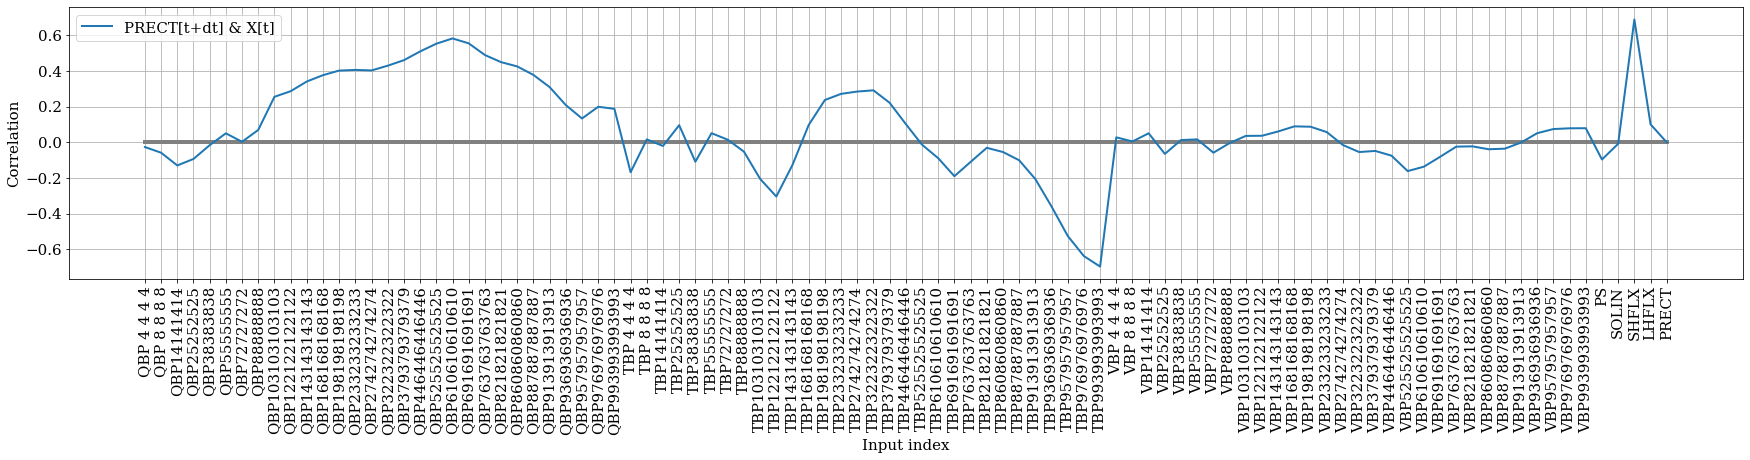

In [492]:
plt.figure(figsize=(30,5))
plt.plot(np.arange(0,95),0*np.arange(0,95)**0,color='gray',linewidth=2*lw)
plt.plot(correlations[:,-1,0],label='PRECT[t+dt] & X[t]')
plt.xticks(np.arange(0,95),raw_vars_name,rotation='vertical')
plt.ylabel('Correlation')
plt.xlabel('Input index')
plt.grid()
plt.legend()

In [424]:
pcmci.verbosity = 1
results = pcmci.run_pcmci(selected_links = sel_links, tau_min = 0, tau_max=0, pc_alpha=None)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
selected_links = {94: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (27, 0), (28, 0), (29, 0), (30, 0), (31, 0), (32, 0), (33, 0), (34, 0), (35, 0), (36, 0), (37, 0), (38, 0), (39, 0), (40, 0), (41, 0), (42, 0), (43, 0), (44, 0), (45, 0), (46, 0), (47, 0), (48, 0), (49, 0), (50, 0), (51, 0), (52, 0), (53, 0), (54, 0), (55, 0), (56, 0), (57, 0), (58, 0), (59, 0), (60, 0), (61, 0), (62, 0), (63, 0), (64, 0), (65, 0), (66, 0), (67, 0), (68, 0), (69, 0), (70, 0), (71, 0), (72, 0), (73, 0), (74, 0), (75, 0), (76, 0), (77, 0), (78, 0), (79, 0), (80, 0), (81, 0), (82, 0), (83, 0), (84, 0), (85, 0), (86, 0), (87, 0), (88, 0), (89, 0), (90, 0), (91, 0), (92, 0), (93, 0)], 0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10

In [425]:
results.keys()

dict_keys(['val_matrix', 'p_matrix', 'q_matrix', 'conf_matrix'])

Text(0.5, 1.0, 'Number of points with p<0.05 is 79')

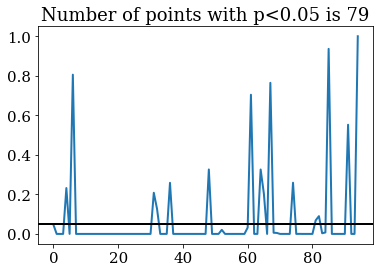

In [426]:
plt.plot(results['p_matrix'][:,-1,0])
plt.axhline(y=0.05,color='k')
plt.title('Number of points with p<0.05 is '+str(np.sum(results['p_matrix'][:,-1,0]<0.05)))

In [428]:
results['p_matrix'].shape

(95, 95, 1)

Repeat for all the named variables

In [ ]:
tau_min = 0
tau_max = 0
children = [94]
parents = np.arange(0,94)

In [461]:
val = {}
pmat = {}
link = {}
nlink = np.zeros((159-94,))

In [464]:
for ioup in np.arange(96,159):
    print('ioup=',ioup,'          ',end='\r')
    raw_vars_test = raw_vars[:,ilat,ilon,np.concatenate((inputs_idx,[ioup]))]
    raw_vars_frame = pp.DataFrame(raw_vars_test,datatime=raw_vars_time,var_names=raw_vars_name)
    pcmci = PCMCI(dataframe=raw_vars_frame,cond_ind_test=parcorr,verbosity=0);
    results = pcmci.run_pcmci(selected_links = sel_links, tau_min = 0, tau_max=0, pc_alpha=None)
    val[ioup] = results['val_matrix']
    pmat[ioup] = results['p_matrix']
    q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=1, fdr_method='fdr_bh')
    link[ioup] = pcmci.return_significant_links(pq_matrix=q_matrix,
                                                val_matrix=results['val_matrix'],
                                                alpha_level=0.01)['link_matrix']
    nlink[ioup-94] = np.sum(link[ioup])

In [475]:
train_data_raw['var_names'][94+np.arange(0,65)].values

array(['PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ',
       'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ',
       'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ', 'PHQ',
       'PHQ', 'PHQ', 'PHQ', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND',
       'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND',
       'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND',
       'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND',
       'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND',
       'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND', 'TPHYSTND',
       'TPHYSTND', 'TPHYSTND', 'FSNT', 'FSNS', 'FLNT', 'FLNS', 'PRECT'],
      dtype=object)

Text(0, 0.5, 'Number of links')

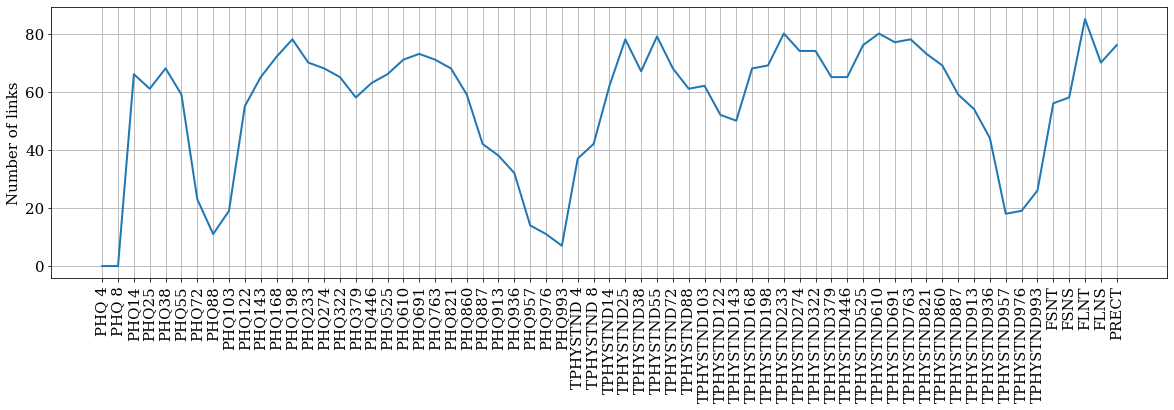

In [498]:
plt.figure(figsize=(20,5))
plt.plot(nlink)
plt.xticks(np.arange(0,65),raw_vars_name_oup,rotation='vertical');
plt.grid()
plt.ylabel('Number of links')

In [496]:
ioup = 94+29
print(raw_vars_name_oup[ioup-94],'is connected to',raw_vars_name_inp[link[ioup][:-1,-1,0]])

PHQ993 is connected to ['QBP913' 'QBP976' 'QBP993' 'TBP957' 'TBP976' 'TBP993' 'LHFLX']


In [497]:
ioup = 94+29+30
print(raw_vars_name_oup[ioup-94],'is connected to',raw_vars_name_inp[link[ioup][:-1,-1,0]])

TPHYSTND993 is connected to ['QBP55' 'QBP274' 'QBP322' 'QBP379' 'QBP691' 'QBP763' 'QBP821' 'QBP860'
 'QBP887' 'QBP913' 'QBP936' 'QBP993' 'TBP55' 'TBP322' 'TBP525' 'TBP913'
 'TBP936' 'TBP957' 'TBP976' 'TBP993' 'VBP38' 'VBP379' 'VBP446' 'SOLIN'
 'SHFLX' 'LHFLX']


In [457]:
ioup = 94+29+30
print(raw_vars_name_oup[ioup-94],'is connected to',raw_vars_name_inp[link[ioup][:-1,-1,0]])

PRECT is connected to ['QBP 8' 'QBP14' 'QBP25' 'QBP55' 'QBP88' 'QBP103' 'QBP122' 'QBP143'
 'QBP168' 'QBP198' 'QBP233' 'QBP274' 'QBP322' 'QBP379' 'QBP446' 'QBP525'
 'QBP610' 'QBP691' 'QBP763' 'QBP821' 'QBP860' 'QBP887' 'QBP913' 'QBP936'
 'QBP957' 'QBP976' 'QBP993' 'TBP 4' 'TBP25' 'TBP38' 'TBP55' 'TBP88'
 'TBP103' 'TBP122' 'TBP143' 'TBP168' 'TBP198' 'TBP233' 'TBP274' 'TBP322'
 'TBP379' 'TBP446' 'TBP610' 'TBP691' 'TBP763' 'TBP860' 'TBP887' 'TBP913'
 'TBP936' 'TBP957' 'TBP976' 'TBP993' 'VBP14' 'VBP25' 'VBP72' 'VBP103'
 'VBP122' 'VBP143' 'VBP168' 'VBP198' 'VBP233' 'VBP322' 'VBP379' 'VBP446'
 'VBP525' 'VBP610' 'VBP691' 'VBP860' 'VBP887' 'VBP936' 'VBP957' 'VBP976'
 'VBP993' 'PS' 'SHFLX' 'LHFLX']


### Raw data with tendencies from previous timestep

In [31]:
raw_vars.shape

(5759, 64, 128, 159)

In [176]:
tau_min = 0
tau_max = 0
children = [Nvars-2] # -2 because excluding the first two PHQ that are constant (0)
parents = np.arange(0,Nvars-2)

In [177]:
sel_links = select_links(tau_min, tau_max, parents, children)

In [178]:
sel_links

{157: [(0, 0),
  (1, 0),
  (2, 0),
  (3, 0),
  (4, 0),
  (5, 0),
  (6, 0),
  (7, 0),
  (8, 0),
  (9, 0),
  (10, 0),
  (11, 0),
  (12, 0),
  (13, 0),
  (14, 0),
  (15, 0),
  (16, 0),
  (17, 0),
  (18, 0),
  (19, 0),
  (20, 0),
  (21, 0),
  (22, 0),
  (23, 0),
  (24, 0),
  (25, 0),
  (26, 0),
  (27, 0),
  (28, 0),
  (29, 0),
  (30, 0),
  (31, 0),
  (32, 0),
  (33, 0),
  (34, 0),
  (35, 0),
  (36, 0),
  (37, 0),
  (38, 0),
  (39, 0),
  (40, 0),
  (41, 0),
  (42, 0),
  (43, 0),
  (44, 0),
  (45, 0),
  (46, 0),
  (47, 0),
  (48, 0),
  (49, 0),
  (50, 0),
  (51, 0),
  (52, 0),
  (53, 0),
  (54, 0),
  (55, 0),
  (56, 0),
  (57, 0),
  (58, 0),
  (59, 0),
  (60, 0),
  (61, 0),
  (62, 0),
  (63, 0),
  (64, 0),
  (65, 0),
  (66, 0),
  (67, 0),
  (68, 0),
  (69, 0),
  (70, 0),
  (71, 0),
  (72, 0),
  (73, 0),
  (74, 0),
  (75, 0),
  (76, 0),
  (77, 0),
  (78, 0),
  (79, 0),
  (80, 0),
  (81, 0),
  (82, 0),
  (83, 0),
  (84, 0),
  (85, 0),
  (86, 0),
  (87, 0),
  (88, 0),
  (89, 0),
  (90, 0),
  (9

In [179]:
val = {}
pmat = {}
link = {}
nlink = np.zeros((Nvars-2,))

In [180]:
raw_vars_time = DT*np.arange(0,raw_vars.shape[0]-1)/(24*3600)

In [181]:
parcorr = ParCorr(significance='analytic')

In [182]:
for ioup in np.arange(96,Nvars):
    print('ioup=',ioup,'          ',end='\r')
    raw_vars_inp = raw_vars[1:,ilat,ilon,inputs_idx]
    raw_vars_oup = raw_vars[1:,ilat,ilon,[ioup]]
    raw_vars_oup_previous_timestep = raw_vars[:-1,ilat,ilon,output_idx[2:]]
    raw_vars_combined = np.concatenate((raw_vars_inp,
                                        raw_vars_oup_previous_timestep,
                                        raw_vars_oup),axis=-1)
    raw_vars_nam = np.concatenate((raw_vars_name_inp+'[t]',
                                   raw_vars_name_oup[2:]+'[t-DT]',
                                   [raw_vars_name_oup[ioup-94]+'t']))
    raw_vars_frame = pp.DataFrame(raw_vars_combined,datatime=raw_vars_time,var_names=raw_vars_nam)
    pcmci = PCMCI(dataframe=raw_vars_frame,cond_ind_test=parcorr,verbosity=0);
    results = pcmci.run_pcmci(selected_links = sel_links, tau_min = 0, tau_max=0, pc_alpha=None)
    val[ioup] = results['val_matrix'][:,-1,0]
    pmat[ioup] = results['p_matrix'][:,-1,0]
    q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=0, fdr_method='fdr_bh')
    link[ioup] = pcmci.return_significant_links(pq_matrix=q_matrix,
                                                val_matrix=results['val_matrix'],
                                                alpha_level=0.01)['link_matrix']
    link[ioup] = link[ioup][:,-1,0]
    nlink[ioup-94] = np.sum(link[ioup])

Compare with what we would find using simple correlations

In [183]:
corr  = {}

In [184]:
for ioup in np.arange(96,Nvars):
    print('ioup=',ioup,'          ',end='\r')
    raw_vars_inp = raw_vars[1:,ilat,ilon,inputs_idx]
    raw_vars_oup = raw_vars[1:,ilat,ilon,[ioup]]
    raw_vars_oup_previous_timestep = raw_vars[:-1,ilat,ilon,output_idx[2:]]
    raw_vars_combined = np.concatenate((raw_vars_inp,
                                        raw_vars_oup_previous_timestep),axis=-1)
    corr[ioup] = np.zeros((Nvars-2,))
    for ivar in range(Nvars-2):
        corr[ioup][ivar] = np.corrcoef(x=raw_vars_combined[:,ivar],y=raw_vars_oup[:,0])[0,1]

Visualization

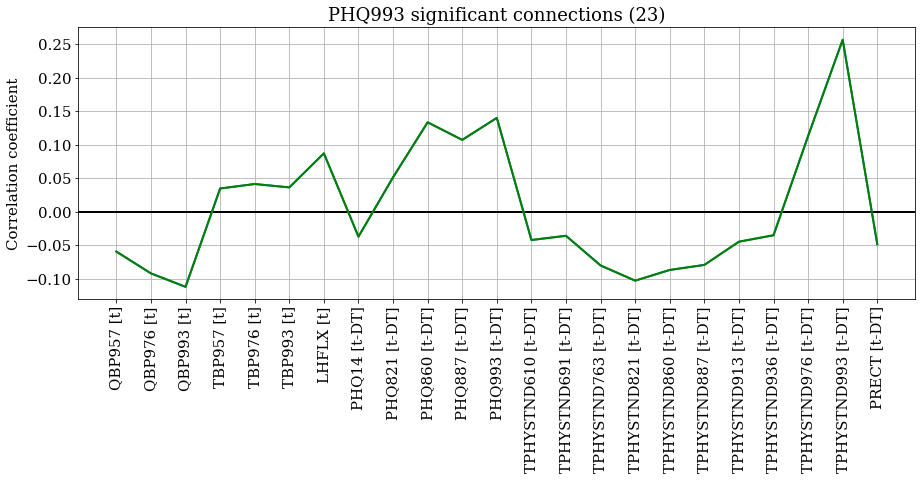

In [201]:
ioup = 94+29
plt.figure(figsize=(15,5))
raw_vars_nam = np.concatenate((raw_vars_name_inp+' [t]',
                               raw_vars_name_oup[2:]+' [t-DT]',
                               [raw_vars_name_oup[ioup-94]+' [t]']))
plt.axhline(y=0,color='k')
plt.plot(val[ioup][link[ioup]])
plt.plot(corr[ioup][link[ioup][:-1]],color='g')
plt.xticks(np.arange(0,int(nlink[ioup-94])),raw_vars_nam[link[ioup]],rotation='vertical');
plt.title(raw_vars_name_oup[ioup-94]+' significant connections ('+str(int(nlink[ioup-94]))+')')
plt.ylabel('Correlation coefficient')
plt.grid()

In [202]:
raw_vars_nam[np.flip(np.argsort(np.abs(corr[ioup])))][:23]

array(['TPHYSTND993 [t-DT]', 'PHQ993 [t-DT]', 'PHQ860 [t-DT]',
       'TPHYSTND976 [t-DT]', 'QBP993 [t]', 'PHQ887 [t-DT]',
       'TPHYSTND821 [t-DT]', 'QBP976 [t]', 'LHFLX [t]',
       'TPHYSTND860 [t-DT]', 'TPHYSTND763 [t-DT]', 'TPHYSTND887 [t-DT]',
       'QBP957 [t]', 'PHQ821 [t-DT]', 'PRECT [t-DT]',
       'TPHYSTND913 [t-DT]', 'TPHYSTND610 [t-DT]', 'TBP976 [t]',
       'PHQ14 [t-DT]', 'TBP993 [t]', 'TPHYSTND691 [t-DT]', 'TBP957 [t]',
       'TPHYSTND936 [t-DT]'], dtype=object)

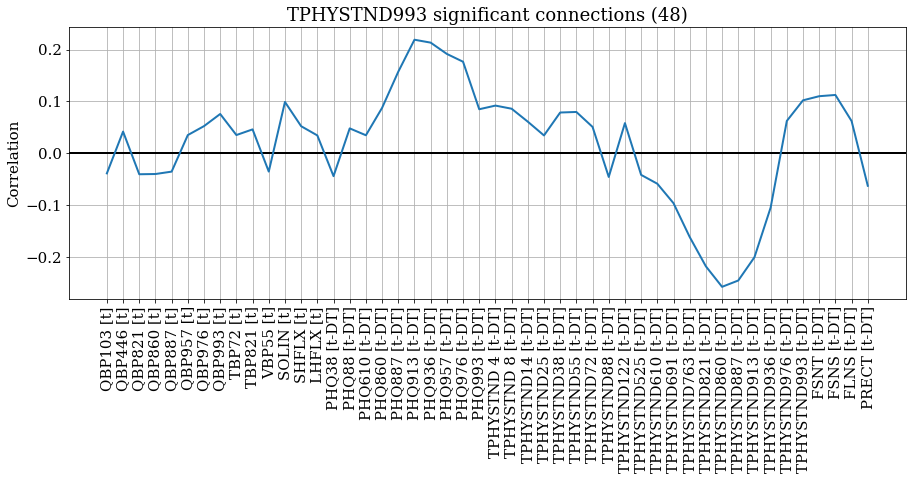

In [204]:
ioup = 94+29+30
plt.figure(figsize=(15,5))
raw_vars_nam = np.concatenate((raw_vars_name_inp+' [t]',
                               raw_vars_name_oup[2:]+' [t-DT]',
                               [raw_vars_name_oup[ioup-94]+' [t]']))
plt.axhline(y=0,color='k')
plt.plot(val[ioup][link[ioup]])
plt.xticks(np.arange(0,int(nlink[ioup-94])),raw_vars_nam[link[ioup]],rotation='vertical');
plt.title(raw_vars_name_oup[ioup-94]+' significant connections ('+str(int(nlink[ioup-94]))+')')
plt.ylabel('Correlation')
plt.grid()

In [205]:
raw_vars_nam[np.flip(np.argsort(np.abs(corr[ioup])))][:48]

array(['TPHYSTND860 [t-DT]', 'TPHYSTND887 [t-DT]', 'PHQ913 [t-DT]',
       'TPHYSTND821 [t-DT]', 'PHQ936 [t-DT]', 'TPHYSTND913 [t-DT]',
       'PHQ957 [t-DT]', 'PHQ976 [t-DT]', 'TPHYSTND763 [t-DT]',
       'PHQ887 [t-DT]', 'FSNS [t-DT]', 'FSNT [t-DT]',
       'TPHYSTND936 [t-DT]', 'TPHYSTND993 [t-DT]', 'SOLIN [t]',
       'TPHYSTND691 [t-DT]', 'TPHYSTND 4 [t-DT]', 'PHQ860 [t-DT]',
       'TPHYSTND 8 [t-DT]', 'PHQ993 [t-DT]', 'TPHYSTND55 [t-DT]',
       'TPHYSTND38 [t-DT]', 'QBP993 [t]', 'TPHYSTND976 [t-DT]',
       'FLNS [t-DT]', 'PRECT [t-DT]', 'TPHYSTND14 [t-DT]',
       'TPHYSTND122 [t-DT]', 'TPHYSTND610 [t-DT]', 'QBP976 [t]',
       'SHFLX [t]', 'TPHYSTND72 [t-DT]', 'PHQ88 [t-DT]', 'TBP821 [t]',
       'TPHYSTND88 [t-DT]', 'PHQ38 [t-DT]', 'QBP446 [t]',
       'TPHYSTND525 [t-DT]', 'QBP821 [t]', 'QBP860 [t]', 'QBP103 [t]',
       'TBP72 [t]', 'QBP957 [t]', 'QBP887 [t]', 'PHQ610 [t-DT]',
       'VBP55 [t]', 'LHFLX [t]', 'TPHYSTND25 [t-DT]'], dtype=object)

### Raw data, can PCMCI find optimal time lag?

In [15]:
lon_test = 150
lat_test = 5

In [19]:
ilon = np.argmin(np.abs(lon_test-coor.lon.values))
ilat = np.argmin(np.abs(lat_test-coor.lat.values))

In [20]:
tau_min = 0
tau_max = 10
children = [Nvars-2] # -2 because excluding the first two PHQ that are constant (0)
parents = np.arange(0,Nvars-2)

In [21]:
raw_vars_time = DT*np.arange(0,raw_vars.shape[0]-1)/(24*3600)

In [25]:
parcorr = ParCorr(significance='analytic')

In [26]:
sel_links = select_links(tau_min, tau_max, parents, children)

In [27]:
val = {}
pmat = {}
link = {}
nlink = np.zeros((Nvars-2,11))

In [28]:
for ioup in np.arange(96,Nvars):
    print('ioup=',ioup,'          ',end='\r')
    raw_vars_inp = raw_vars[1:,ilat,ilon,inputs_idx]
    raw_vars_oup = raw_vars[1:,ilat,ilon,[ioup]]
    raw_vars_oup_previous_timestep = raw_vars[:-1,ilat,ilon,output_idx[2:]]
    raw_vars_combined = np.concatenate((raw_vars_inp,
                                        raw_vars_oup_previous_timestep,
                                        raw_vars_oup),axis=-1)
    raw_vars_nam = np.concatenate((raw_vars_name_inp+'[t]',
                                   raw_vars_name_oup[2:]+'[t-DT]',
                                   [raw_vars_name_oup[ioup-94]+'t']))
    raw_vars_frame = pp.DataFrame(raw_vars_combined,datatime=raw_vars_time,var_names=raw_vars_nam)
    pcmci = PCMCI(dataframe=raw_vars_frame,cond_ind_test=parcorr,verbosity=0);
    results = pcmci.run_pcmci(selected_links = sel_links, tau_min = 0, tau_max=tau_max, pc_alpha=None)
    val[ioup] = results['val_matrix'][:,-1,:]
    pmat[ioup] = results['p_matrix'][:,-1,:]
    q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=tau_max, fdr_method='fdr_bh')
    link[ioup] = pcmci.return_significant_links(pq_matrix=q_matrix,
                                                val_matrix=results['val_matrix'],
                                                alpha_level=0.01)['link_matrix']
    link[ioup] = link[ioup][:,-1,:]
    nlink[ioup-94] = np.sum(link[ioup],axis=0)

In [29]:
nlink

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [26., 12.,  4., ...,  0.,  1.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [31]:
nlink.shape

(157, 11)

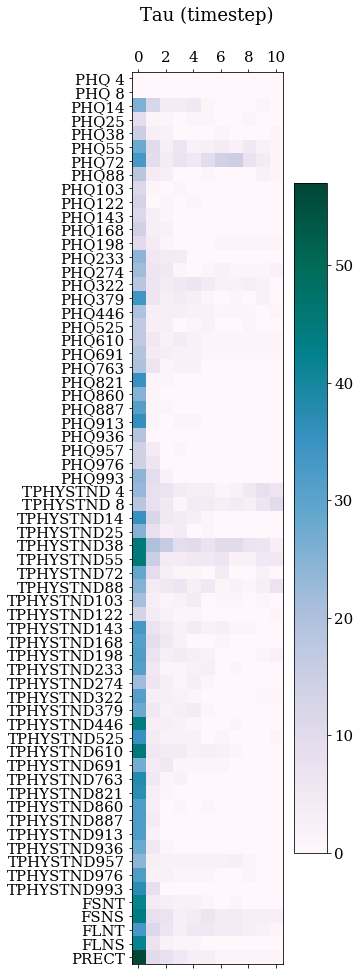

In [48]:
plt.matshow(nlink[:65,:],cmap='PuBuGn')
plt.yticks(np.arange(0,65),raw_vars_name_oup);
plt.title('Tau (timestep)')
plt.colorbar()

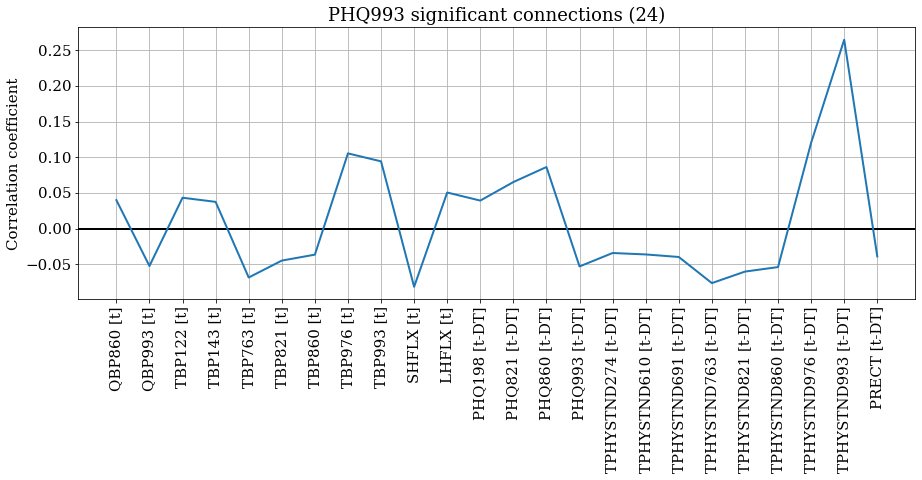

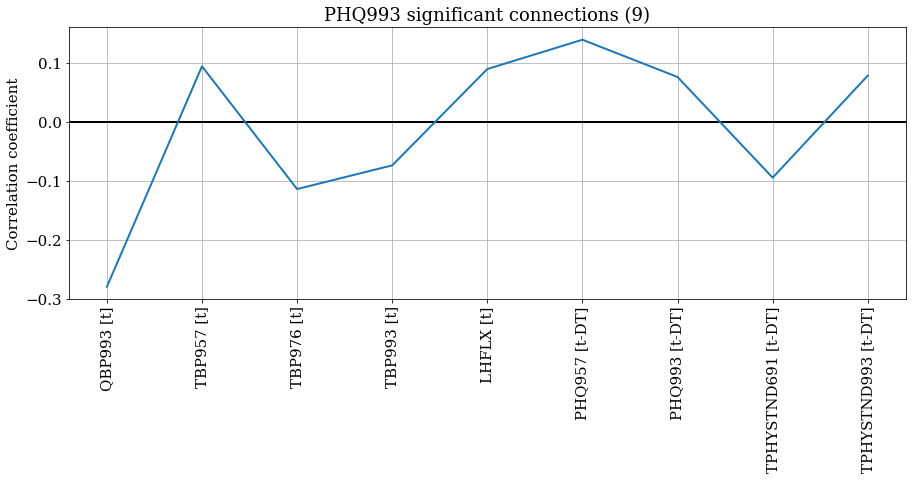

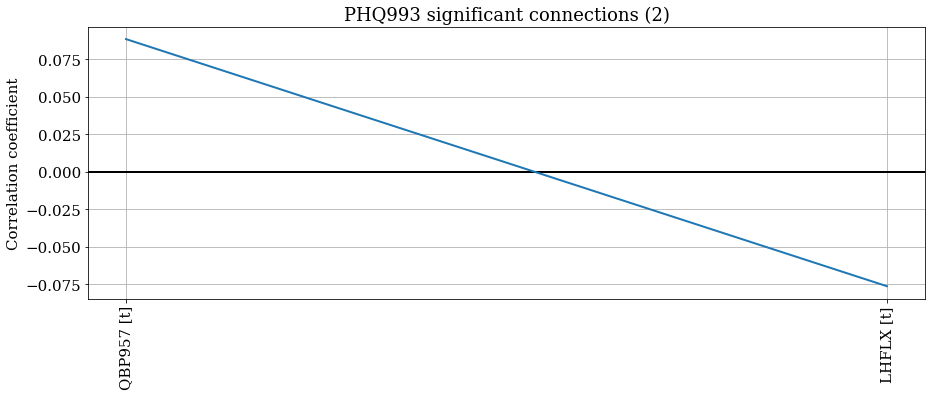

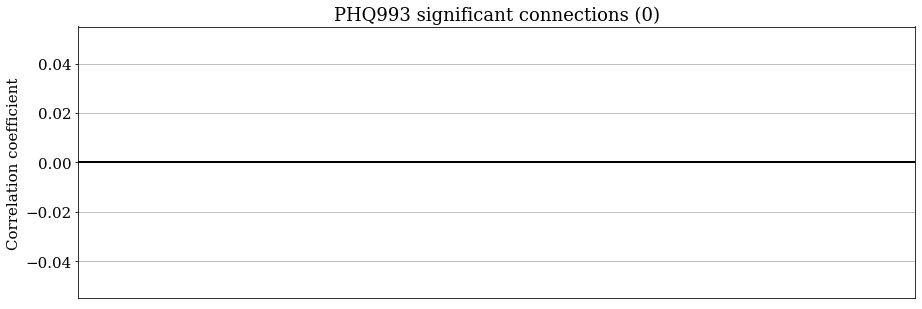

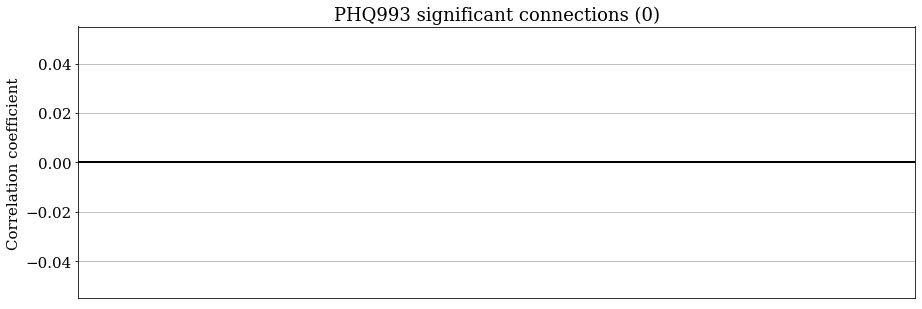

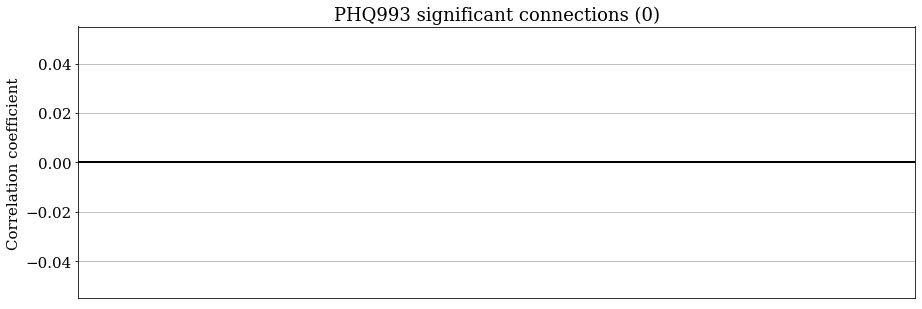

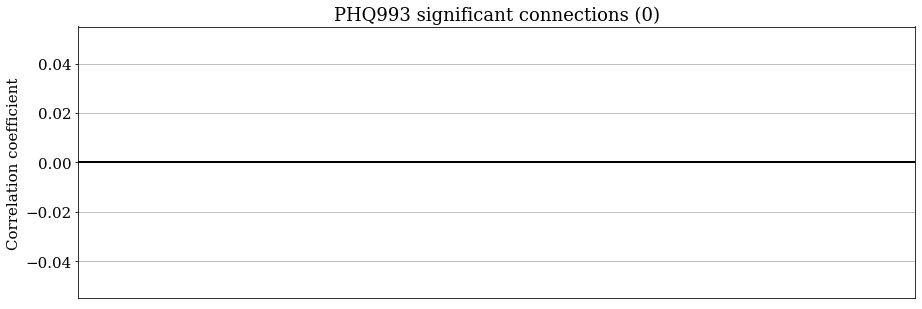

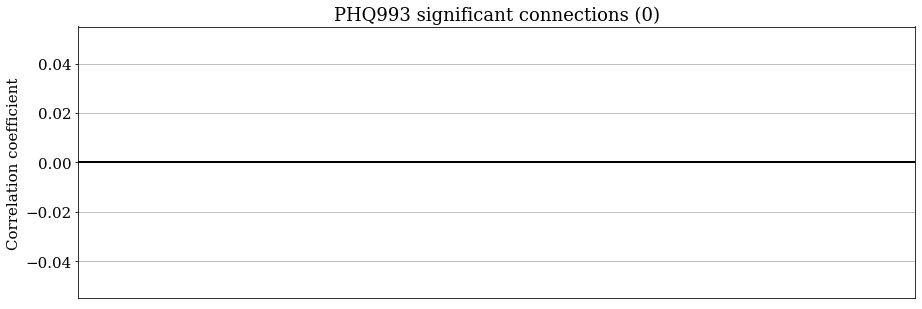

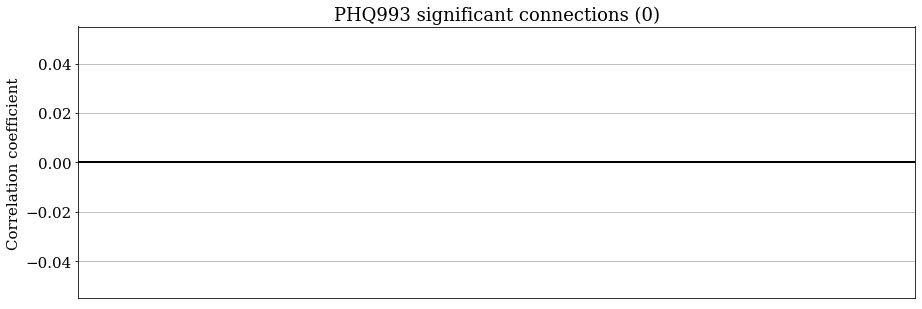

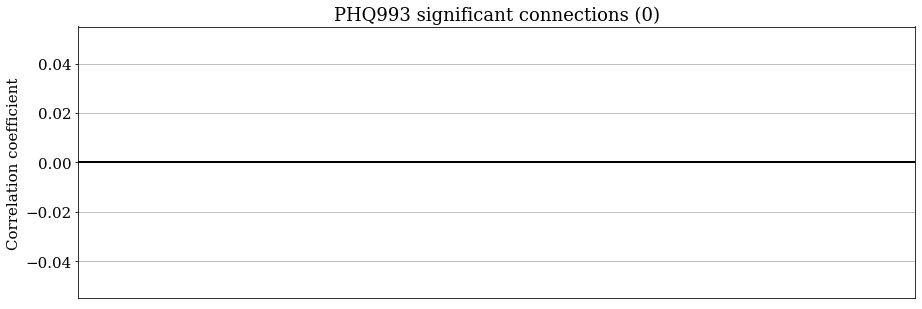

In [32]:
ioup = 94+29
for itau in range(10):
    plt.figure(figsize=(15,5))
    raw_vars_nam = np.concatenate((raw_vars_name_inp+' [t]',
                                   raw_vars_name_oup[2:]+' [t-DT]',
                                   [raw_vars_name_oup[ioup-94]+' [t]']))
    linktau = link[ioup][:,itau]
    plt.axhline(y=0,color='k')
    plt.plot(val[ioup][:,itau][linktau])
    plt.xticks(np.arange(0,int(nlink[ioup-94,itau])),raw_vars_nam[linktau],rotation='vertical');
    plt.title(raw_vars_name_oup[ioup-94]+' significant connections ('+str(int(nlink[ioup-94,itau]))+')')
    plt.ylabel('Correlation coefficient')
    plt.grid()

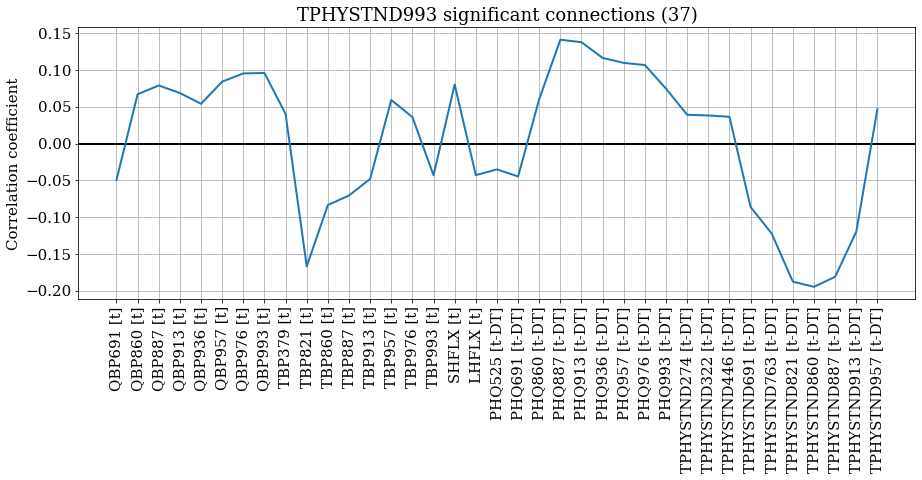

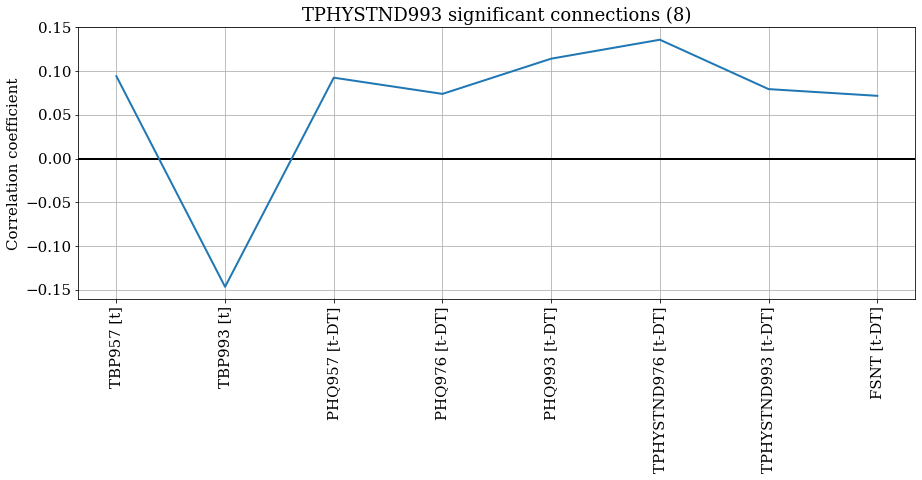

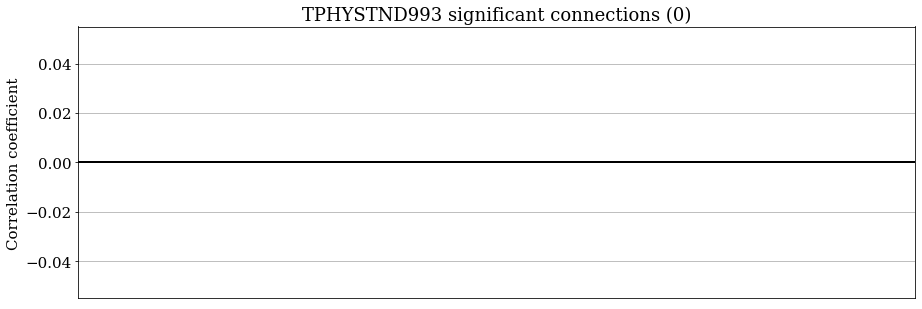

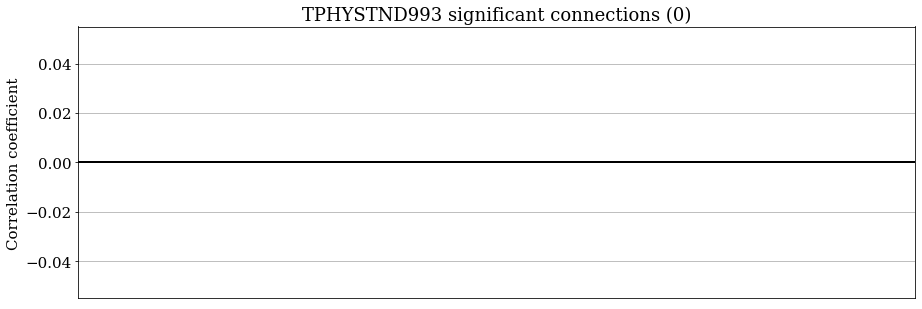

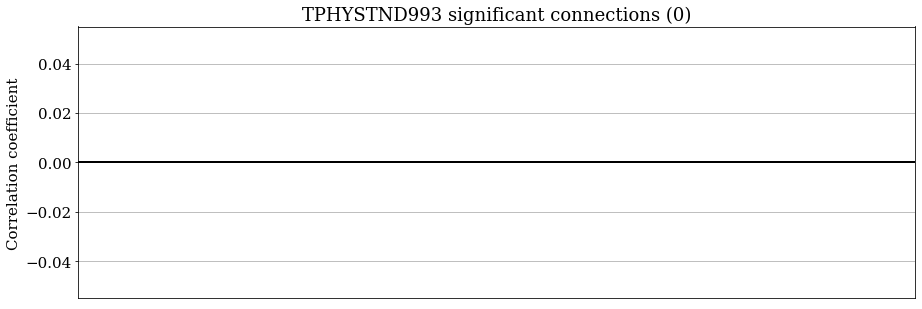

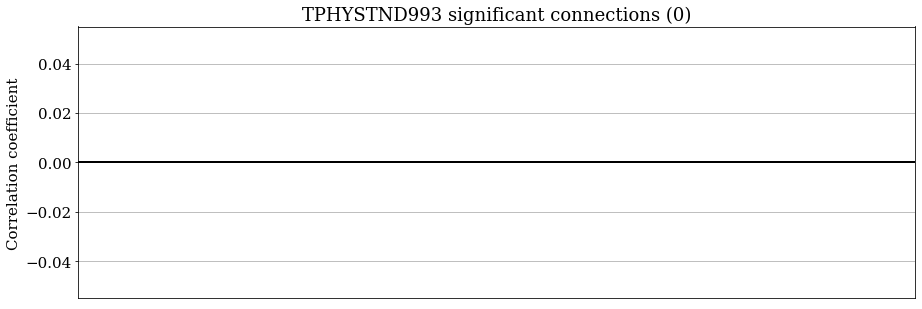

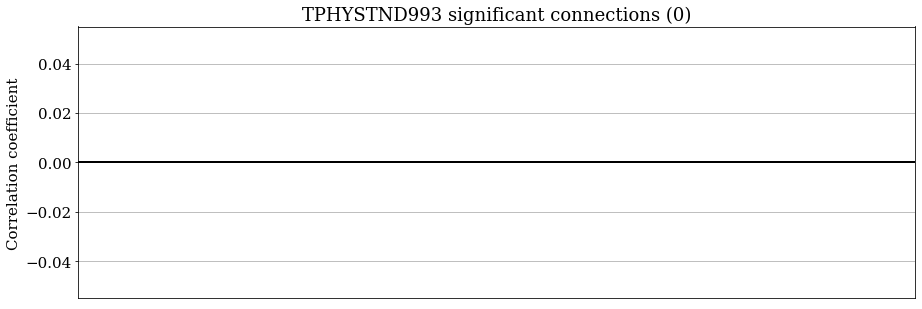

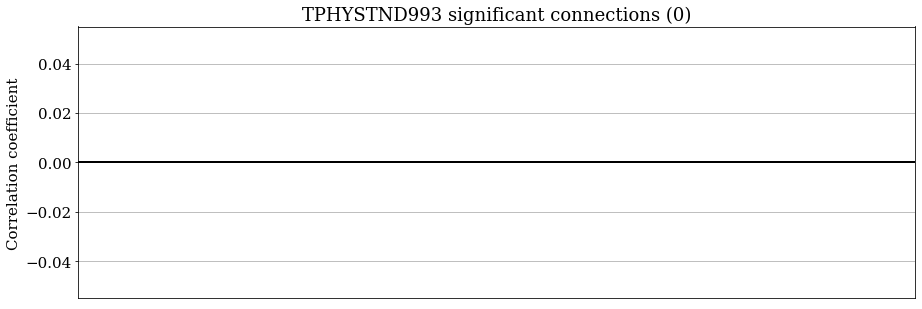

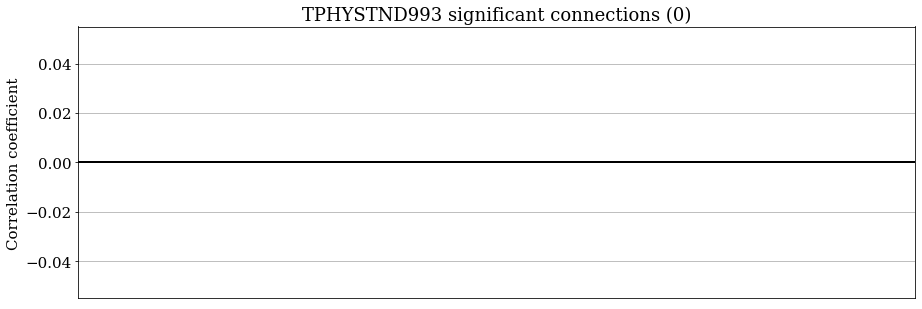

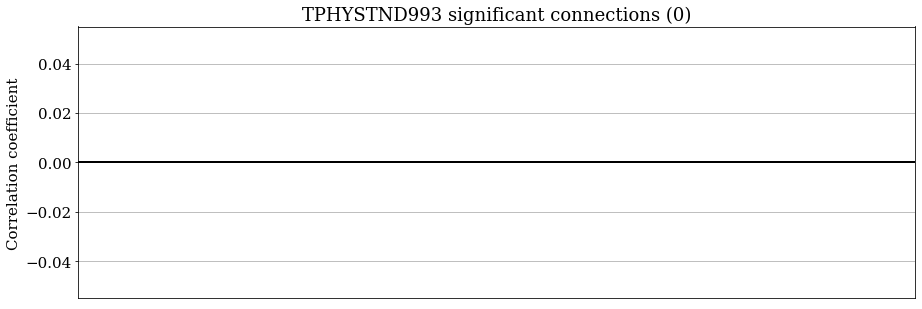

In [33]:
ioup = 94+29+30
for itau in range(10):
    plt.figure(figsize=(15,5))
    raw_vars_nam = np.concatenate((raw_vars_name_inp+' [t]',
                                   raw_vars_name_oup[2:]+' [t-DT]',
                                   [raw_vars_name_oup[ioup-94]+' [t]']))
    linktau = link[ioup][:,itau]
    plt.axhline(y=0,color='k')
    plt.plot(val[ioup][:,itau][linktau])
    plt.xticks(np.arange(0,int(nlink[ioup-94,itau])),raw_vars_nam[linktau],rotation='vertical');
    plt.title(raw_vars_name_oup[ioup-94]+' significant connections ('+str(int(nlink[ioup-94,itau]))+')')
    plt.ylabel('Correlation coefficient')
    plt.grid()

### PCA data, single latitude and longitude

In [45]:
lon_test = 150
lat_test = 5
ilon = np.argmin(np.abs(lon_test-coor.lon.values))
ilat = np.argmin(np.abs(lat_test-coor.lat.values))
inputs_idx = np.arange(0,94)

In [46]:
val_pca = {}
pmat_pca = {}
link_pca = {}
nlink_pca = np.zeros((159-94,))

In [53]:
pca_vars_time = DT*np.arange(0,pca_vars_test.shape[0])/(24*3600)

In [58]:
parcorr = ParCorr(significance='analytic')

In [62]:
sel_links = select_links(0, 0, np.arange(0,94), [94])

In [63]:
for ioup in np.arange(96,159):
    print('ioup=',ioup,'          ',end='\r')
    inpoup_idx = np.concatenate((inputs_idx,[ioup]))
    pca_vars_test = pca_vars[:,ilat,ilon,inpoup_idx]
    pca_vars_frame = pp.DataFrame(pca_vars_test,datatime=pca_vars_time,
                                  var_names=train_data_PCA['var_names'][inpoup_idx].values)
    pcmci = PCMCI(dataframe=pca_vars_frame,cond_ind_test=parcorr,verbosity=0);
    results = pcmci.run_pcmci(selected_links = sel_links, tau_min = 0, tau_max=0, pc_alpha=None)
    val_pca[ioup] = results['val_matrix']
    pmat_pca[ioup] = results['p_matrix']
    q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=0, fdr_method='fdr_bh')
    link_pca[ioup] = pcmci.return_significant_links(pq_matrix=q_matrix,
                                                val_matrix=results['val_matrix'],
                                                alpha_level=0.01)['link_matrix']
    nlink_pca[ioup-94] = np.sum(link_pca[ioup])

Text(0, 0.5, 'Number of links')

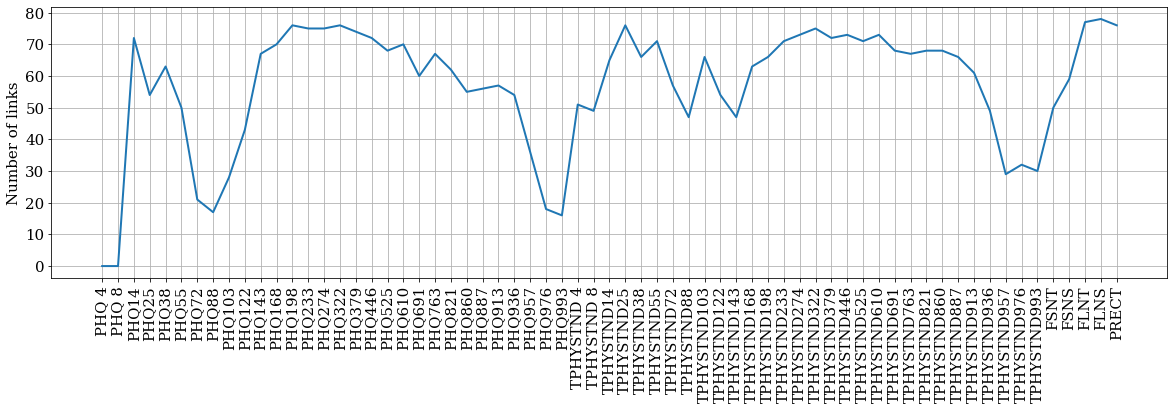

In [65]:
plt.figure(figsize=(20,5))
plt.plot(nlink_pca)
plt.xticks(np.arange(0,65),pca_vars_name_oup,rotation='vertical');
plt.grid()
plt.ylabel('Number of links')

In [68]:
ioup = 94+29
print(pca_vars_name_oup[ioup-94],'is connected to',pca_vars_name_inp[link_pca[ioup][:-1,-1,0]])

PHQ993 is connected to ['PCA_21' 'PCA_22' 'PCA_24' 'PCA_27' 'PCA_31' 'PCA_34' 'PCA_39' 'PCA_40'
 'PCA_41' 'PCA_50' 'PCA_52' 'PCA_59' 'PCA_61' 'PCA_66' 'PCA_70' 'PCA_81']


In [69]:
ioup = 94+29+30
print(pca_vars_name_oup[ioup-94],'is connected to',pca_vars_name_inp[link_pca[ioup][:-1,-1,0]])

TPHYSTND993 is connected to ['PCA_2' 'PCA_4' 'PCA_7' 'PCA_8' 'PCA_9' 'PCA_10' 'PCA_11' 'PCA_12'
 'PCA_19' 'PCA_20' 'PCA_22' 'PCA_23' 'PCA_24' 'PCA_28' 'PCA_29' 'PCA_31'
 'PCA_41' 'PCA_42' 'PCA_44' 'PCA_49' 'PCA_52' 'PCA_55' 'PCA_57' 'PCA_58'
 'PCA_59' 'PCA_61' 'PCA_74' 'PCA_78' 'PCA_79' 'PCA_85']


In [70]:
ioup = 158
print(pca_vars_name_oup[ioup-94],'is connected to',pca_vars_name_inp[link_pca[ioup][:-1,-1,0]])

PRECT is connected to ['PCA_1' 'PCA_2' 'PCA_3' 'PCA_4' 'PCA_5' 'PCA_6' 'PCA_7' 'PCA_8' 'PCA_9'
 'PCA_10' 'PCA_11' 'PCA_12' 'PCA_13' 'PCA_14' 'PCA_15' 'PCA_16' 'PCA_17'
 'PCA_18' 'PCA_19' 'PCA_20' 'PCA_21' 'PCA_22' 'PCA_23' 'PCA_24' 'PCA_25'
 'PCA_29' 'PCA_30' 'PCA_31' 'PCA_34' 'PCA_35' 'PCA_36' 'PCA_37' 'PCA_38'
 'PCA_40' 'PCA_42' 'PCA_43' 'PCA_45' 'PCA_46' 'PCA_47' 'PCA_48' 'PCA_50'
 'PCA_51' 'PCA_52' 'PCA_53' 'PCA_55' 'PCA_56' 'PCA_58' 'PCA_59' 'PCA_60'
 'PCA_61' 'PCA_64' 'PCA_66' 'PCA_67' 'PCA_68' 'PCA_69' 'PCA_70' 'PCA_71'
 'PCA_72' 'PCA_73' 'PCA_74' 'PCA_75' 'PCA_76' 'PCA_77' 'PCA_78' 'PCA_81'
 'PCA_82' 'PCA_83' 'PCA_84' 'PCA_85' 'PCA_86' 'PCA_87' 'PCA_89' 'PCA_90'
 'PCA_92' 'PCA_93' 'PCA_94']


### PCA data truncated, single latitude and longitude

In [76]:
lon_test = 150
lat_test = 5
ilon = np.argmin(np.abs(lon_test-coor.lon.values))
ilat = np.argmin(np.abs(lat_test-coor.lat.values))
inputs_idx = np.arange(0,94)


In [80]:
pca30.shape

(5759, 64, 128, 95)

In [81]:
val_pca30 = {}
pmat_pca30 = {}
link_pca30 = {}
nlink_pca30 = np.zeros((95-30,))

In [79]:
parcorr = ParCorr(significance='analytic')

In [82]:
sel_links = select_links(0, 0, np.arange(0,30), [30])

In [87]:
for ioup in np.arange(32,95):
    print('ioup=',ioup,'          ',end='\r')
    inpoup_idx = np.concatenate((np.arange(0,30),[ioup]))
    pca30_vars_test = pca30[:,ilat,ilon,inpoup_idx]
    pca30_vars_frame = pp.DataFrame(pca30_vars_test,datatime=pca_vars_time,
                                  var_names=train_data_PCA['var_names'][inpoup_idx].values)
    pcmci = PCMCI(dataframe=pca30_vars_frame,cond_ind_test=parcorr,verbosity=0);
    results = pcmci.run_pcmci(selected_links = sel_links, tau_min = 0, tau_max=0, pc_alpha=None)
    val_pca30[ioup] = results['val_matrix']
    pmat_pca30[ioup] = results['p_matrix']
    q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=0, fdr_method='fdr_bh')
    link_pca30[ioup] = pcmci.return_significant_links(pq_matrix=q_matrix,
                                                val_matrix=results['val_matrix'],
                                                alpha_level=0.01)['link_matrix']
    nlink_pca30[ioup-30] = np.sum(link_pca30[ioup])

Text(0, 0.5, 'Number of links')

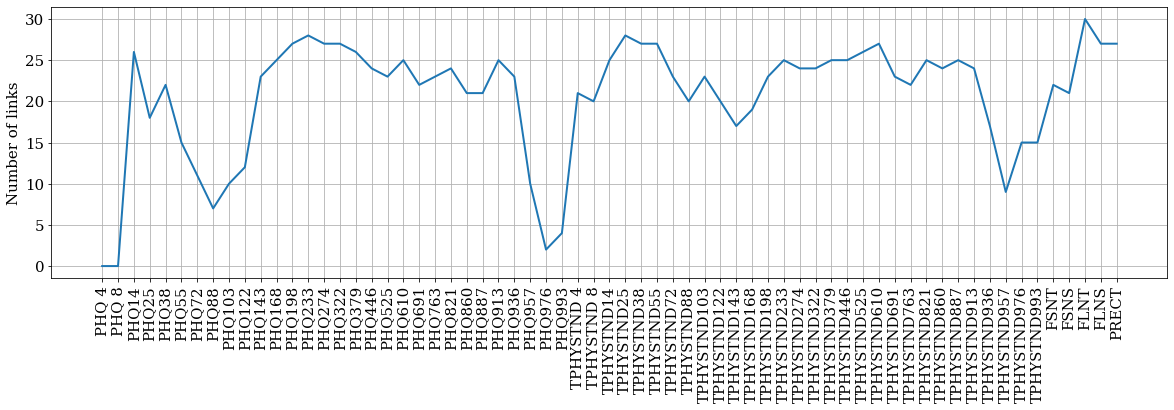

In [88]:
plt.figure(figsize=(20,5))
plt.plot(nlink_pca30)
plt.xticks(np.arange(0,65),pca_vars_name_oup,rotation='vertical');
plt.grid()
plt.ylabel('Number of links')

In [99]:
ioup = 30+29
print(pca_vars_name_oup[ioup-30],'is connected to',pca30_vars_name_inp[link_pca30[ioup][:-1,-1,0]])

PHQ993 is connected to ['PCA_21' 'PCA_22' 'PCA_24' 'PCA_27']


In [100]:
pmat_pca30[ioup].shape

(31, 31, 1)

Text(0.5, 1.0, 'Number of points with p<0.05 is 6')

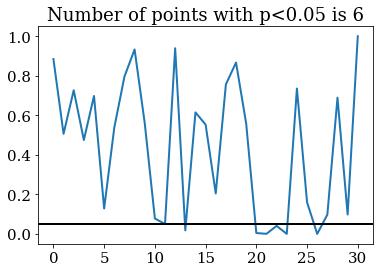

In [102]:
plt.plot(pmat_pca30[ioup][:,-1,0])
plt.axhline(y=0.05,color='k')
plt.title('Number of points with p<0.05 is '+str(np.sum(pmat_pca30[ioup][:,-1,0]<0.05)))

In [103]:
ioup = 30+29+30
print(pca_vars_name_oup[ioup-30],'is connected to',pca30_vars_name_inp[link_pca30[ioup][:-1,-1,0]])

TPHYSTND993 is connected to ['PCA_2' 'PCA_4' 'PCA_7' 'PCA_8' 'PCA_9' 'PCA_10' 'PCA_11' 'PCA_12'
 'PCA_19' 'PCA_20' 'PCA_22' 'PCA_23' 'PCA_24' 'PCA_28' 'PCA_29']


Text(0.5, 1.0, 'Number of points with p<0.05 is 21')

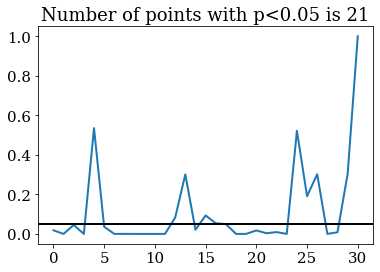

In [104]:
plt.plot(pmat_pca30[ioup][:,-1,0])
plt.axhline(y=0.05,color='k')
plt.title('Number of points with p<0.05 is '+str(np.sum(pmat_pca30[ioup][:,-1,0]<0.05)))

In [105]:
ioup = 94
print(pca_vars_name_oup[ioup-30],'is connected to',pca30_vars_name_inp[link_pca30[ioup][:-1,-1,0]])

PRECT is connected to ['PCA_1' 'PCA_2' 'PCA_3' 'PCA_4' 'PCA_5' 'PCA_6' 'PCA_7' 'PCA_8' 'PCA_9'
 'PCA_10' 'PCA_11' 'PCA_12' 'PCA_13' 'PCA_14' 'PCA_15' 'PCA_16' 'PCA_17'
 'PCA_18' 'PCA_19' 'PCA_20' 'PCA_21' 'PCA_22' 'PCA_23' 'PCA_24' 'PCA_25'
 'PCA_29' 'PCA_30']


Text(0.5, 1.0, 'Number of points with p<0.05 is 28')

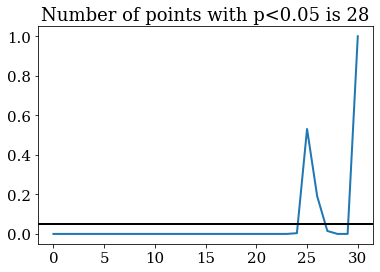

In [106]:
plt.plot(pmat_pca30[ioup][:,-1,0])
plt.axhline(y=0.05,color='k')
plt.title('Number of points with p<0.05 is '+str(np.sum(pmat_pca30[ioup][:,-1,0]<0.05)))

## Maps of p-value as a way to consistently select inputs

### Raw data, test for each latitude circle including tendencies at previous timestep

In [116]:
val = {}
pmat = {}
link = {}
nlink = np.zeros((128,159-94))

In [117]:
for ilon in np.arange(0,128):
    val[ilon] = {}
    pmat[ilon] = {}
    link[ilon] = {}
    for ioup in np.arange(96,Nvars):
        print('ilon=',ilon,'and ioup=',ioup,'          ',end='\r')
        raw_vars_inp = raw_vars[1:,ilat,ilon,inputs_idx]
        raw_vars_oup = raw_vars[1:,ilat,ilon,[ioup]]
        raw_vars_oup_previous_timestep = raw_vars[:-1,ilat,ilon,output_idx[2:]]
        raw_vars_combined = np.concatenate((raw_vars_inp,
                                            raw_vars_oup_previous_timestep,
                                            raw_vars_oup),axis=-1)
        raw_vars_nam = np.concatenate((raw_vars_name_inp+'[t]',
                                       raw_vars_name_oup[2:]+'[t-DT]',
                                       [raw_vars_name_oup[ioup-94]+'t']))
        raw_vars_frame = pp.DataFrame(raw_vars_combined,datatime=raw_vars_time,var_names=raw_vars_nam)
        pcmci = PCMCI(dataframe=raw_vars_frame,cond_ind_test=parcorr,verbosity=0);
        results = pcmci.run_pcmci(selected_links = sel_links, tau_min = 0, tau_max=0, pc_alpha=None)
        val[ilon][ioup] = results['val_matrix'][:,-1,0]
        pmat[ilon][ioup] = results['p_matrix'][:,-1,0]
        q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=0, fdr_method='fdr_bh')
        link[ilon][ioup] = pcmci.return_significant_links(pq_matrix=q_matrix,
                                                    val_matrix=results['val_matrix'],
                                                    alpha_level=0.01)['link_matrix']
        link[ilon][ioup] = link[ilon][ioup][:,-1,0]
        nlink[ilon,ioup-94] = np.sum(link[ilon][ioup])

In [139]:
val[ilon][ioup].shape

(158,)

In [140]:
link_intersect = {}
nlink_intersect = np.zeros((159-94,))
val_intersect = {}

In [141]:
for ioup in np.arange(96,Nvars):
    link_intersect[ioup] = link[0][ioup]
    val_intersect[ioup] = val[0][ioup]
    for ilon in range(127):
        link_intersect[ioup] *= link[ilon+1][ioup]
        val_intersect[ioup] = ((ilon+1)*val_intersect[ioup]+val[ilon+1][ioup])/(ilon+2)
    nlink_intersect[ioup-94] = np.sum(link_intersect[ioup])

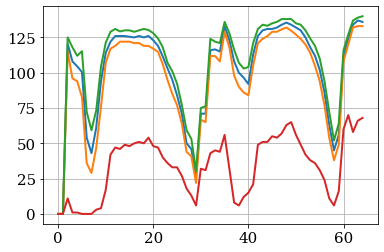

In [142]:
plt.plot(np.median(nlink,axis=0))
plt.plot(np.percentile(a=nlink,q=25,axis=0))
plt.plot(np.percentile(a=nlink,q=75,axis=0))
plt.plot(nlink_intersect)
plt.grid()

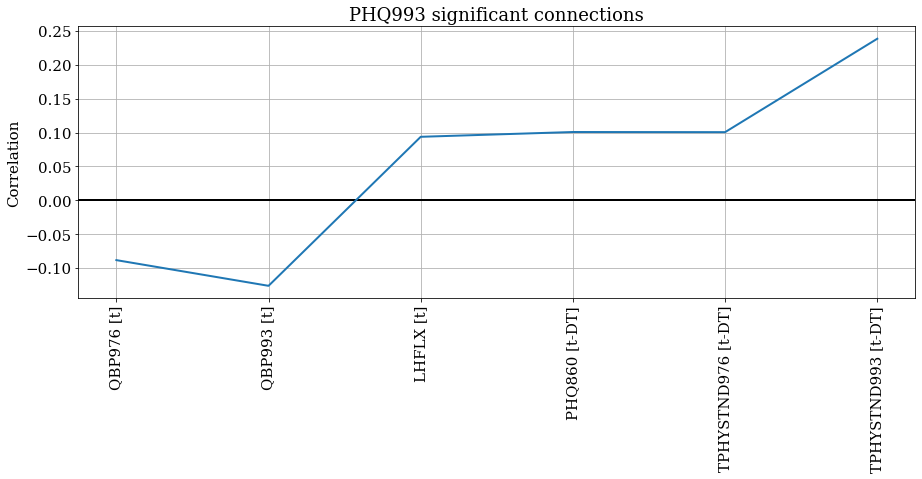

In [143]:
ioup = 94+29
plt.figure(figsize=(15,5))
raw_vars_nam = np.concatenate((raw_vars_name_inp+' [t]',
                               raw_vars_name_oup[2:]+' [t-DT]',
                               [raw_vars_name_oup[ioup-94]+' [t]']))
plt.axhline(y=0,color='k')
plt.plot(val_intersect[ioup][link_intersect[ioup]])
plt.xticks(np.arange(0,int(nlink_intersect[ioup-94])),raw_vars_nam[link_intersect[ioup]],rotation='vertical');
plt.title(raw_vars_name_oup[ioup-94]+' significant connections')
plt.ylabel('Correlation')
plt.grid()

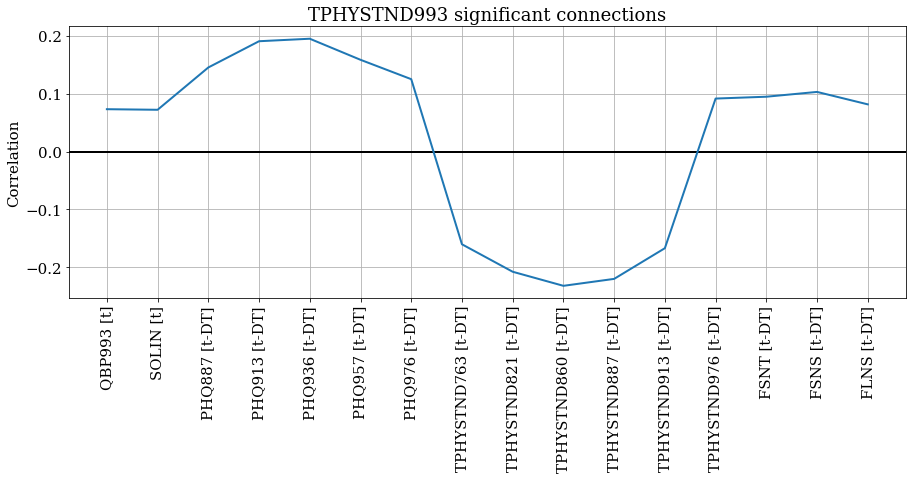

In [145]:
ioup = 94+29+30
plt.figure(figsize=(15,5))
raw_vars_nam = np.concatenate((raw_vars_name_inp+' [t]',
                               raw_vars_name_oup[2:]+' [t-DT]',
                               [raw_vars_name_oup[ioup-94]+' [t]']))
plt.axhline(y=0,color='k')
plt.plot(val_intersect[ioup][link_intersect[ioup]])
plt.xticks(np.arange(0,int(nlink_intersect[ioup-94])),raw_vars_nam[link_intersect[ioup]],rotation='vertical');
plt.title(raw_vars_name_oup[ioup-94]+' significant connections')
plt.ylabel('Correlation')
plt.grid()

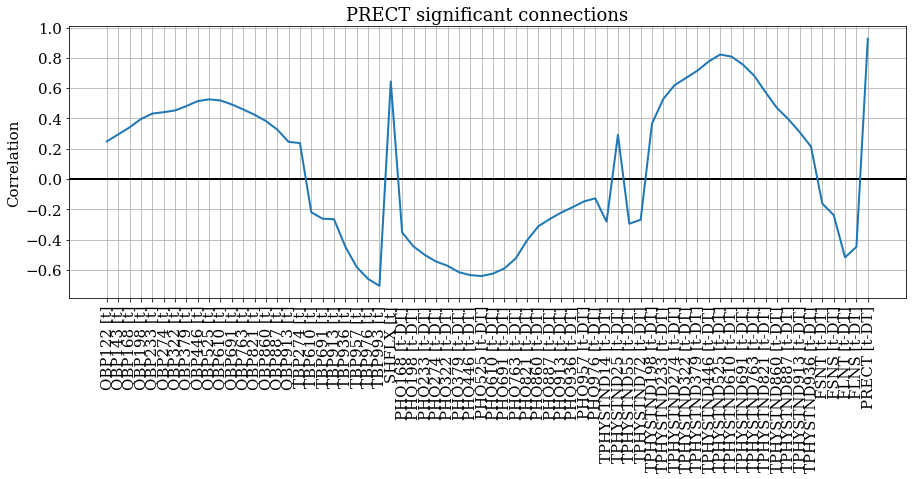

In [147]:
ioup = 94+29+30+5
plt.figure(figsize=(15,5))
raw_vars_nam = np.concatenate((raw_vars_name_inp+' [t]',
                               raw_vars_name_oup[2:]+' [t-DT]',
                               [raw_vars_name_oup[ioup-94]+' [t]']))
plt.axhline(y=0,color='k')
plt.plot(val_intersect[ioup][link_intersect[ioup]])
plt.xticks(np.arange(0,int(nlink_intersect[ioup-94])),raw_vars_nam[link_intersect[ioup]],rotation='vertical');
plt.title(raw_vars_name_oup[ioup-94]+' significant connections')
plt.ylabel('Correlation')
plt.grid()

### PCA data truncated

In [107]:
valmap_pca30 = np.zeros((64,128,95,30))
pmap_pca30 = np.zeros((64,128,95,30))

In [110]:
for ioup in np.arange(32,95):
    inpoup_idx = np.concatenate((np.arange(0,30),[ioup]))
    for ilat in range(64):
        print('ioup=',ioup,'ilat=',ilat,'          ',end='\r')
        for ilon in range(128):
            pca30_vars_test = pca30[:,ilat,ilon,inpoup_idx]
            pca30_vars_frame = pp.DataFrame(pca30_vars_test,datatime=pca_vars_time,
                                  var_names=train_data_PCA['var_names'][inpoup_idx].values)
            pcmci = PCMCI(dataframe=pca30_vars_frame,cond_ind_test=parcorr,verbosity=0);
            results = pcmci.run_pcmci(selected_links = sel_links, tau_min = 0, tau_max=0, pc_alpha=None)
            valmap_pca30[ilat,ilon,ioup,:] = results['val_matrix'][:-1,-1,0]
            pmap_pca30[ilat,ilon,ioup,:] = results['p_matrix'][:-1,-1,0]

/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/tigramite/independence_tests/parcorr.py:94: RuntimeWarning: invalid value encountered in true_divide
  array /= array.std(axis=1).reshape(dim, 1)


ValueError: nans after standardizing, possibly constant array!

Text(0.5, 1.0, 'PHQ993#points w/ p<0.05 is 0')

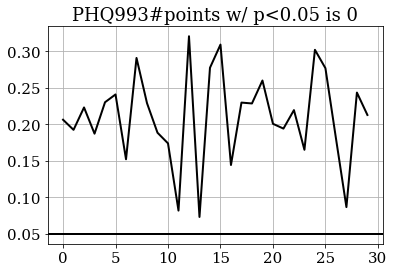

In [121]:
ioup = 30+29
plt.plot(np.mean(pmap_pca30[:,:,ioup,:],axis=(0,1)),color='k')
plt.axhline(y=0.05,color='k')
plt.grid()
plt.title(pca_vars_name_oup[ioup-30]+'#points w/ p<0.05 is '+str(np.sum(np.mean(pmap_pca30[:,:,ioup,:])<0.05)))

Text(0.5, 1.0, 'PHQ993#points w/ p<0.05 is 1')

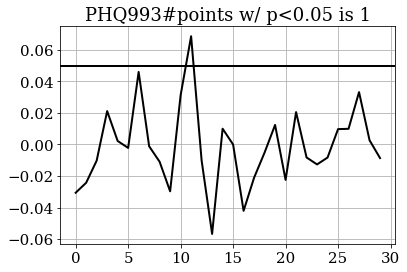

In [122]:
ioup = 30+29
plt.plot(np.mean(valmap_pca30[:,:,ioup,:],axis=(0,1)),color='k')
plt.axhline(y=0.05,color='k')
plt.grid()
plt.title(pca_vars_name_oup[ioup-30]+'#points w/ p<0.05 is '+str(np.sum(np.mean(valmap_pca30[:,:,ioup,:])<0.05)))

In [123]:
2

2